In [1]:
import os
import scipy.misc
import numpy as np
import json

# from model import DCGAN
from model_steer2_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
FLAGS = flags.FLAGS

In [2]:
def main(_):
  pp.pprint(flags.FLAGS.__flags)
  
  # expand user name and environment variables
  FLAGS.data_dir = expand_path(FLAGS.data_dir)
  FLAGS.out_dir = expand_path(FLAGS.out_dir)
  FLAGS.out_name = expand_path(FLAGS.out_name)
  FLAGS.checkpoint_dir = expand_path(FLAGS.checkpoint_dir)
  FLAGS.sample_dir = expand_path(FLAGS.sample_dir)

  print('FLAGS.dataset:', FLAGS.dataset)  
  print('FLAGS.output_height', FLAGS.output_height)  
  print('flags.train', FLAGS.train)

  if FLAGS.output_height is None: FLAGS.output_height = FLAGS.input_height
  if FLAGS.input_width is None: FLAGS.input_width = FLAGS.input_height
  if FLAGS.output_width is None: FLAGS.output_width = FLAGS.output_height

  # output folders
  if FLAGS.out_name == "":
      FLAGS.out_name = '{} - {} - {}'.format(timestamp(), FLAGS.data_dir.split('/')[-1], FLAGS.dataset) # penultimate folder of path
      if FLAGS.train:
        FLAGS.out_name += ' - x{}.z{}.{}.y{}.b{}'.format(FLAGS.input_width, FLAGS.z_dim, FLAGS.z_dist, FLAGS.output_width, FLAGS.batch_size)

  FLAGS.out_dir = os.path.join(FLAGS.out_dir, FLAGS.out_name)
  FLAGS.checkpoint_dir = os.path.join(FLAGS.out_dir, FLAGS.checkpoint_dir)
  FLAGS.sample_dir = os.path.join(FLAGS.out_dir, FLAGS.sample_dir)

  if not os.path.exists(FLAGS.checkpoint_dir): os.makedirs(FLAGS.checkpoint_dir)
  if not os.path.exists(FLAGS.sample_dir): os.makedirs(FLAGS.sample_dir)

  with open(os.path.join(FLAGS.out_dir, 'FLAGS.json'), 'w') as f:
    flags_dict = {k:FLAGS[k].value for k in FLAGS}
    json.dump(flags_dict, f, indent=4, sort_keys=True, ensure_ascii=False)
  

  #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
  run_config = tf.ConfigProto()
  run_config.gpu_options.allow_growth=True

  with tf.Session(config=run_config) as sess:
    if FLAGS.dataset == 'mnist':
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          y_dim=10,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)
    else:
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)

    show_all_variables()

    if FLAGS.train:
      dcgan.train(FLAGS)
    else:
      load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
      if not load_success:
        raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)


    # to_json("./web/js/layers.js", [dcgan.h0_w, dcgan.h0_b, dcgan.g_bn0],
    #                 [dcgan.h1_w, dcgan.h1_b, dcgan.g_bn1],
    #                 [dcgan.h2_w, dcgan.h2_b, dcgan.g_bn2],
    #                 [dcgan.h3_w, dcgan.h3_b, dcgan.g_bn3],
    #                 [dcgan.h4_w, dcgan.h4_b, None])

    # Below is codes for visualization
      if FLAGS.export:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'export_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=True, frozen=False)

      if FLAGS.freeze:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'frozen_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=False, frozen=True)

      if FLAGS.visualize:
        OPTION = 1
        visualize(sess, dcgan, FLAGS, OPTION, FLAGS.sample_dir)

# if __name__ == '__main__':
#   tf.app.run()

{'G_img_sum': <absl.flags._flag.BooleanFlag object at 0x7f0c337b1be0>,
 'batch_size': <absl.flags._flag.Flag object at 0x7f0d01fb8710>,
 'beta1': <absl.flags._flag.Flag object at 0x7f0d01fb8668>,
 'checkpoint_dir': <absl.flags._flag.Flag object at 0x7f0c337b14e0>,
 'ckpt_freq': <absl.flags._flag.Flag object at 0x7f0c337b1908>,
 'crop': <absl.flags._flag.BooleanFlag object at 0x7f0c337b16d8>,
 'data_dir': <absl.flags._flag.Flag object at 0x7f0c337b1320>,
 'dataset': <absl.flags._flag.Flag object at 0x7f0c337b1198>,
 'epoch': <absl.flags._flag.Flag object at 0x7f0d0c291a58>,
 'export': <absl.flags._flag.BooleanFlag object at 0x7f0c337b17f0>,
 'freeze': <absl.flags._flag.BooleanFlag object at 0x7f0c337b1860>,
 'h': <tensorflow.python.platform.app._HelpFlag object at 0x7f0c337c9518>,
 'help': <tensorflow.python.platform.app._HelpFlag object at 0x7f0c337c9518>,
 'helpfull': <tensorflow.python.platform.app._HelpfullFlag object at 0x7f0c337c9550>,
 'helpshort': <tensorflow.python.platform.app

 [*] Reading checkpoints... ./out/ckpt/checkpoint
INFO:tensorflow:Restoring parameters from ./out/ckpt/checkpoint/model.b64-800
 [*] Success to read model.b64-800
 [*] Load SUCCESS
Target image:


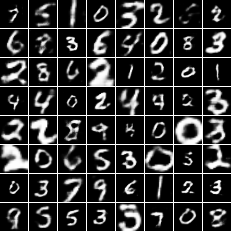

Target mask:


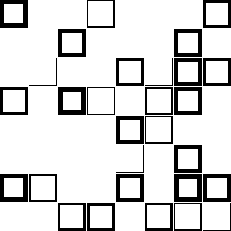

[     800 Epoch:[ 0/25] [   0/1093] time: 5.7049, d_loss: 1.50184369, g_loss: 2.20455647, walk_loss: 2.20455647
[Sample] d_loss: 1.888758897781372, g_loss: 2.2750842571258545, w_loss: 2.2750842571258545
Target image:


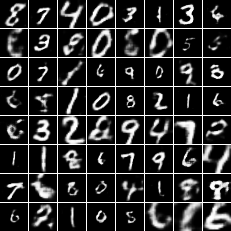

Target mask:


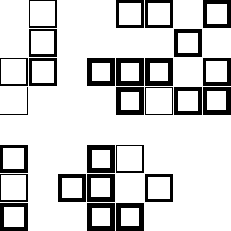

[     801 Epoch:[ 0/25] [   1/1093] time: 10.4340, d_loss: 1.49339902, g_loss: 2.21263814, walk_loss: 2.21263814
Target image:


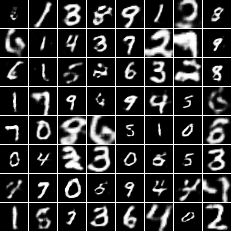

Target mask:


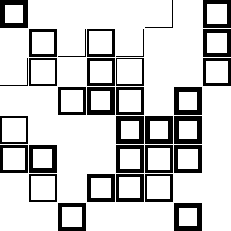

[     802 Epoch:[ 0/25] [   2/1093] time: 10.7210, d_loss: 1.50039899, g_loss: 2.21660590, walk_loss: 2.21660590
Target image:


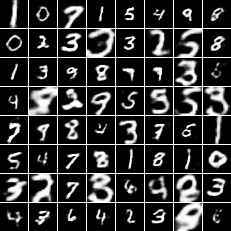

Target mask:


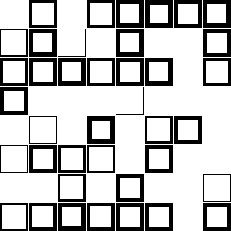

[     803 Epoch:[ 0/25] [   3/1093] time: 11.0288, d_loss: 1.49911308, g_loss: 2.24016714, walk_loss: 2.24016738
Target image:


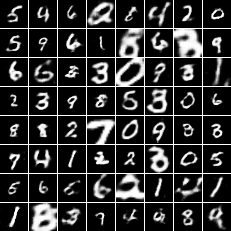

Target mask:


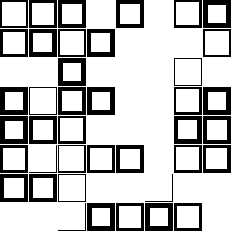

[     804 Epoch:[ 0/25] [   4/1093] time: 11.3240, d_loss: 1.49615502, g_loss: 2.21874022, walk_loss: 2.21873999
Target image:


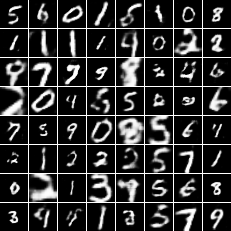

Target mask:


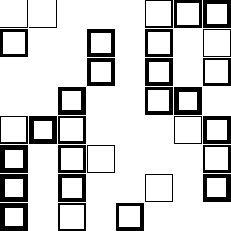

[     805 Epoch:[ 0/25] [   5/1093] time: 11.6253, d_loss: 1.48667920, g_loss: 2.20745492, walk_loss: 2.20745492
Target image:


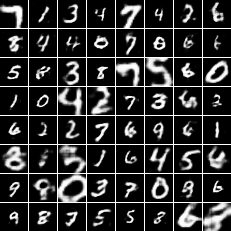

Target mask:


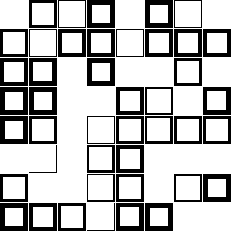

[     806 Epoch:[ 0/25] [   6/1093] time: 11.9132, d_loss: 1.49838161, g_loss: 2.20357156, walk_loss: 2.20357156
Target image:


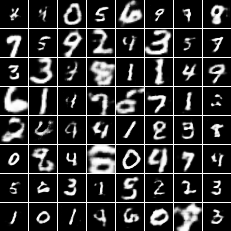

Target mask:


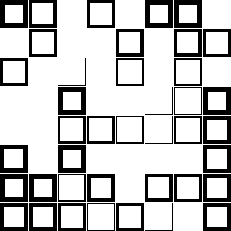

[     807 Epoch:[ 0/25] [   7/1093] time: 12.2160, d_loss: 1.50096703, g_loss: 2.20224142, walk_loss: 2.20224142
Target image:


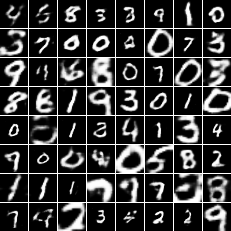

Target mask:


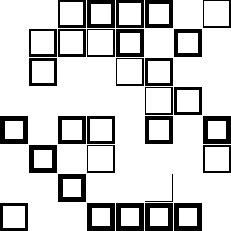

[     808 Epoch:[ 0/25] [   8/1093] time: 12.4858, d_loss: 1.48599815, g_loss: 2.22447371, walk_loss: 2.22447348
Target image:


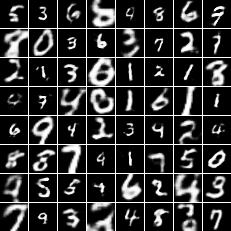

Target mask:


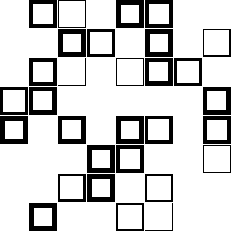

[     809 Epoch:[ 0/25] [   9/1093] time: 12.7329, d_loss: 1.49634635, g_loss: 2.19017577, walk_loss: 2.19017577
Target image:


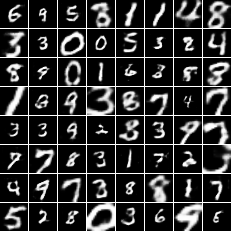

Target mask:


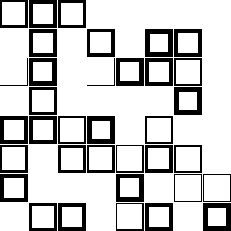

[     810 Epoch:[ 0/25] [  10/1093] time: 12.9726, d_loss: 1.48108029, g_loss: 2.21994495, walk_loss: 2.21994495
Target image:


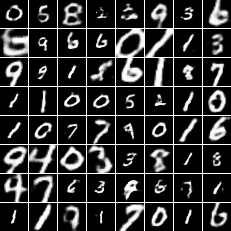

Target mask:


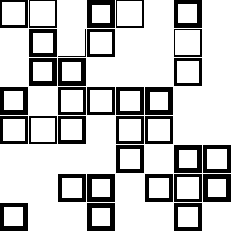

[     811 Epoch:[ 0/25] [  11/1093] time: 13.2782, d_loss: 1.49326789, g_loss: 2.22560716, walk_loss: 2.22560763
Target image:


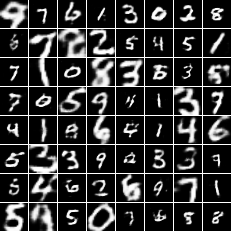

Target mask:


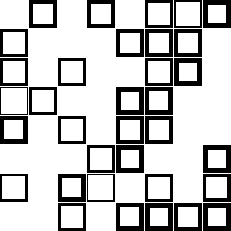

[     812 Epoch:[ 0/25] [  12/1093] time: 13.5608, d_loss: 1.48116922, g_loss: 2.21516204, walk_loss: 2.21516204
Target image:


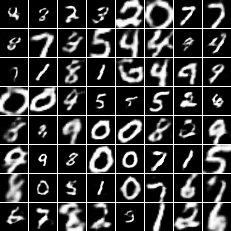

Target mask:


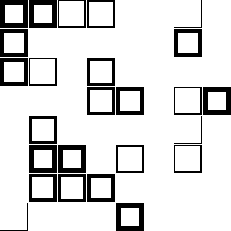

[     813 Epoch:[ 0/25] [  13/1093] time: 13.8683, d_loss: 1.48647463, g_loss: 2.22196436, walk_loss: 2.22196436
Target image:


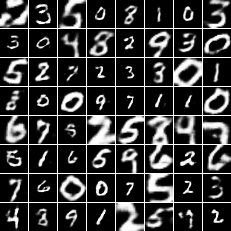

Target mask:


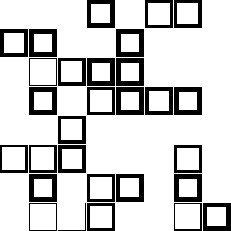

[     814 Epoch:[ 0/25] [  14/1093] time: 14.1489, d_loss: 1.48805976, g_loss: 2.22812510, walk_loss: 2.22812510
Target image:


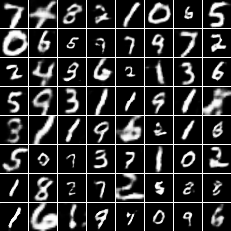

Target mask:


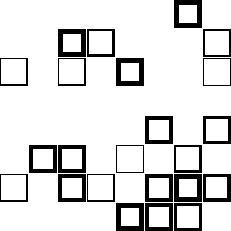

[     815 Epoch:[ 0/25] [  15/1093] time: 14.4620, d_loss: 1.49306166, g_loss: 2.20763397, walk_loss: 2.20763397
Target image:


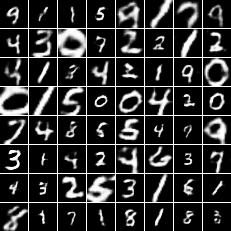

Target mask:


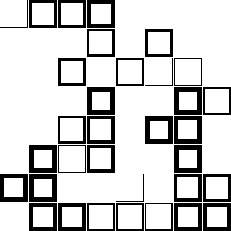

[     816 Epoch:[ 0/25] [  16/1093] time: 14.7289, d_loss: 1.49926555, g_loss: 2.23345113, walk_loss: 2.23345137
Target image:


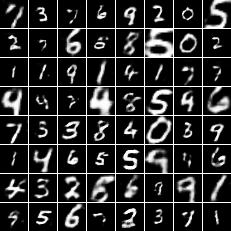

Target mask:


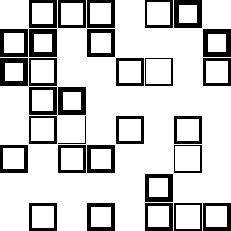

[     817 Epoch:[ 0/25] [  17/1093] time: 15.0070, d_loss: 1.50069964, g_loss: 2.21748281, walk_loss: 2.21748281
Target image:


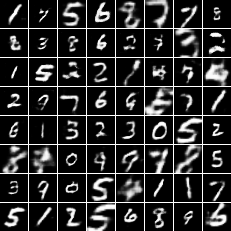

Target mask:


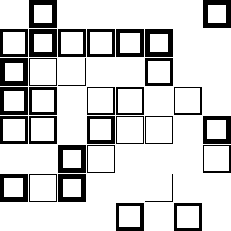

[     818 Epoch:[ 0/25] [  18/1093] time: 15.3411, d_loss: 1.49549961, g_loss: 2.20060301, walk_loss: 2.20060301
Target image:


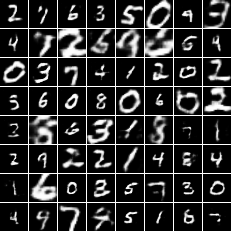

Target mask:


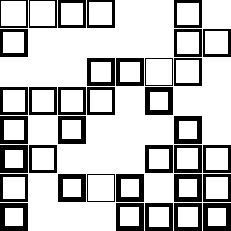

[     819 Epoch:[ 0/25] [  19/1093] time: 15.6144, d_loss: 1.48622632, g_loss: 2.23057055, walk_loss: 2.23057055
Target image:


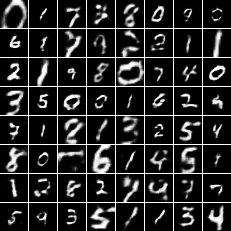

Target mask:


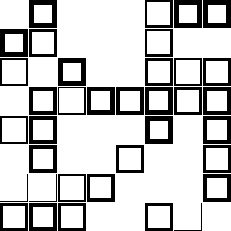

[     820 Epoch:[ 0/25] [  20/1093] time: 15.8993, d_loss: 1.48974848, g_loss: 2.18950343, walk_loss: 2.18950343
Target image:


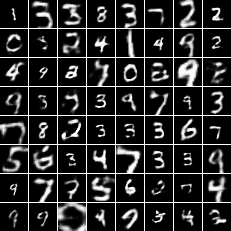

Target mask:


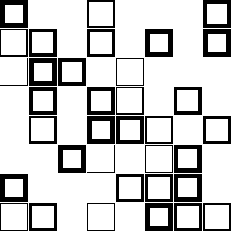

[     821 Epoch:[ 0/25] [  21/1093] time: 16.1883, d_loss: 1.50226808, g_loss: 2.19128323, walk_loss: 2.19128346
Target image:


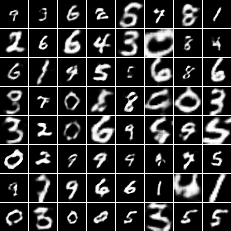

Target mask:


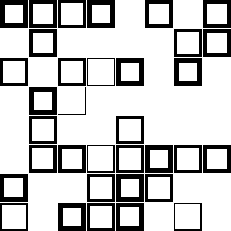

[     822 Epoch:[ 0/25] [  22/1093] time: 16.4387, d_loss: 1.49033868, g_loss: 2.20748281, walk_loss: 2.20748281
Target image:


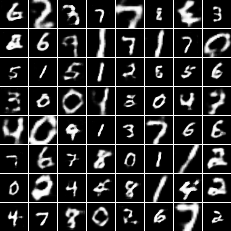

Target mask:


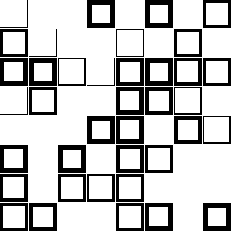

[     823 Epoch:[ 0/25] [  23/1093] time: 16.7180, d_loss: 1.50624490, g_loss: 2.17757392, walk_loss: 2.17757368
Target image:


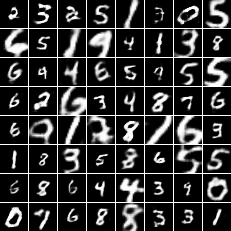

Target mask:


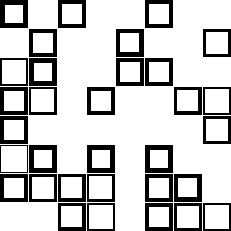

[     824 Epoch:[ 0/25] [  24/1093] time: 16.9597, d_loss: 1.49844515, g_loss: 2.19533587, walk_loss: 2.19533587
Target image:


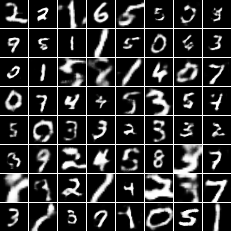

Target mask:


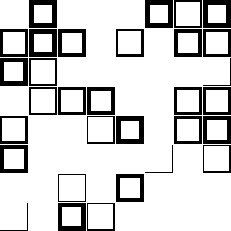

[     825 Epoch:[ 0/25] [  25/1093] time: 17.2069, d_loss: 1.49767590, g_loss: 2.20642924, walk_loss: 2.20642924
Target image:


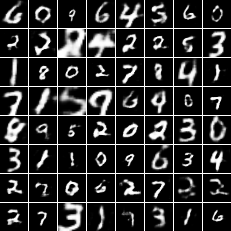

Target mask:


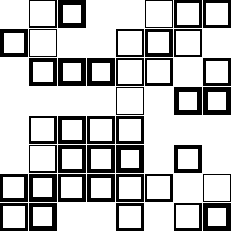

[     826 Epoch:[ 0/25] [  26/1093] time: 17.5156, d_loss: 1.50405049, g_loss: 2.19994092, walk_loss: 2.19994092
Target image:


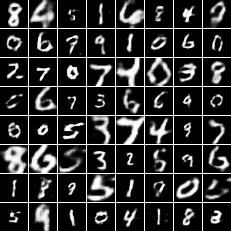

Target mask:


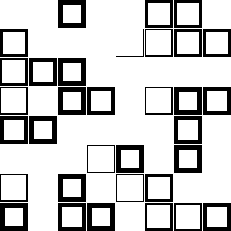

[     827 Epoch:[ 0/25] [  27/1093] time: 17.7928, d_loss: 1.49793494, g_loss: 2.19317532, walk_loss: 2.19317555
Target image:


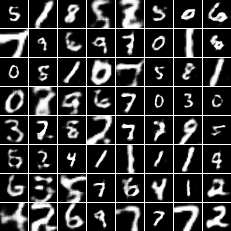

Target mask:


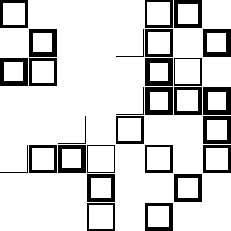

[     828 Epoch:[ 0/25] [  28/1093] time: 18.0875, d_loss: 1.50029922, g_loss: 2.19740510, walk_loss: 2.19740510
Target image:


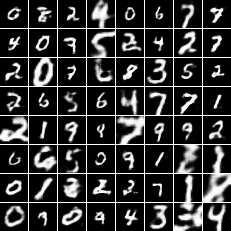

Target mask:


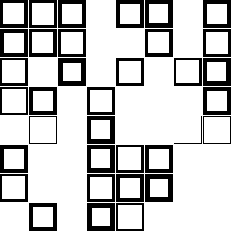

[     829 Epoch:[ 0/25] [  29/1093] time: 18.3551, d_loss: 1.47585535, g_loss: 2.20937490, walk_loss: 2.20937490
Target image:


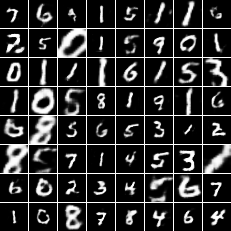

Target mask:


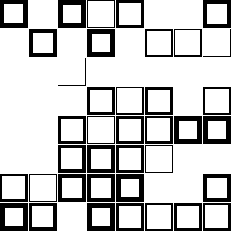

[     830 Epoch:[ 0/25] [  30/1093] time: 18.5977, d_loss: 1.48638260, g_loss: 2.18956709, walk_loss: 2.18956709
Target image:


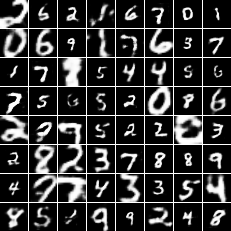

Target mask:


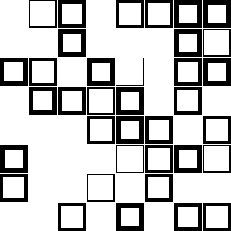

[     831 Epoch:[ 0/25] [  31/1093] time: 18.8385, d_loss: 1.49131978, g_loss: 2.23184299, walk_loss: 2.23184299
Target image:


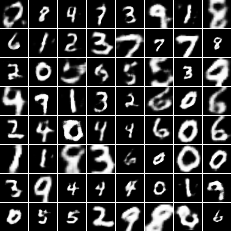

Target mask:


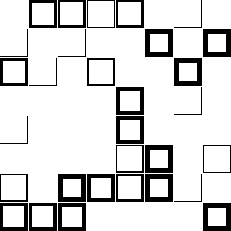

[     832 Epoch:[ 0/25] [  32/1093] time: 19.1142, d_loss: 1.47803235, g_loss: 2.20808840, walk_loss: 2.20808840
Target image:


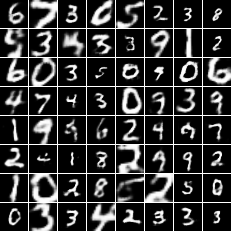

Target mask:


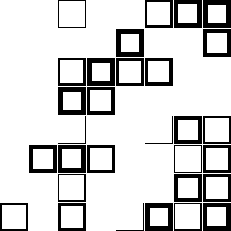

[     833 Epoch:[ 0/25] [  33/1093] time: 19.3615, d_loss: 1.50589526, g_loss: 2.19330239, walk_loss: 2.19330239
Target image:


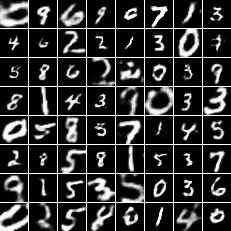

Target mask:


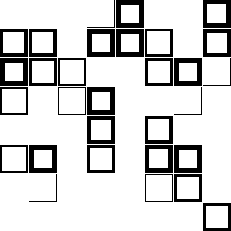

[     834 Epoch:[ 0/25] [  34/1093] time: 19.6384, d_loss: 1.48692095, g_loss: 2.18121672, walk_loss: 2.18121672
Target image:


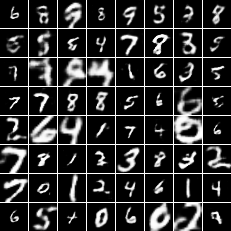

Target mask:


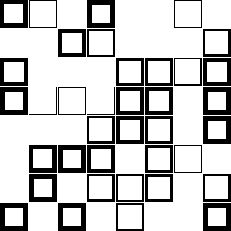

[     835 Epoch:[ 0/25] [  35/1093] time: 19.8912, d_loss: 1.49275899, g_loss: 2.20369267, walk_loss: 2.20369267
Target image:


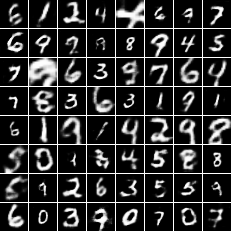

Target mask:


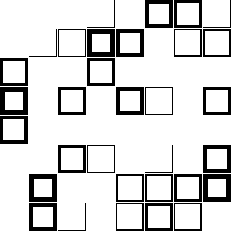

[     836 Epoch:[ 0/25] [  36/1093] time: 20.1376, d_loss: 1.49535275, g_loss: 2.16900063, walk_loss: 2.16900063
Target image:


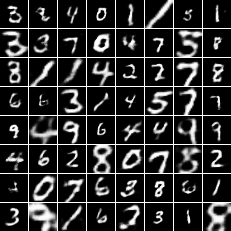

Target mask:


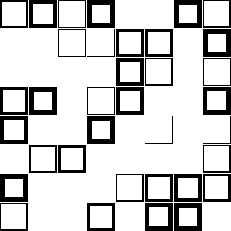

[     837 Epoch:[ 0/25] [  37/1093] time: 20.3860, d_loss: 1.49539030, g_loss: 2.19138122, walk_loss: 2.19138122
Target image:


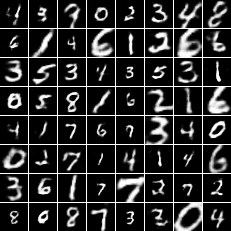

Target mask:


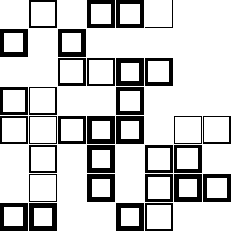

[     838 Epoch:[ 0/25] [  38/1093] time: 20.6521, d_loss: 1.50705504, g_loss: 2.20993161, walk_loss: 2.20993185
Target image:


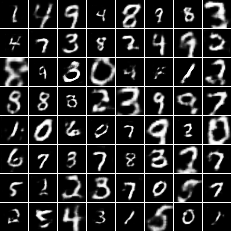

Target mask:


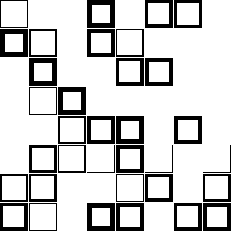

[     839 Epoch:[ 0/25] [  39/1093] time: 20.9316, d_loss: 1.48977351, g_loss: 2.21611762, walk_loss: 2.21611762
Target image:


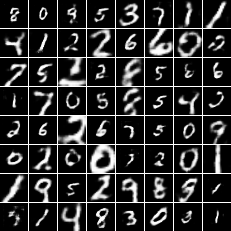

Target mask:


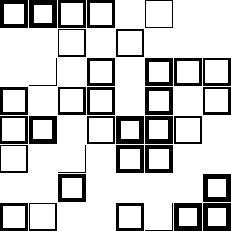

[     840 Epoch:[ 0/25] [  40/1093] time: 21.2109, d_loss: 1.49652195, g_loss: 2.22248912, walk_loss: 2.22248912
Target image:


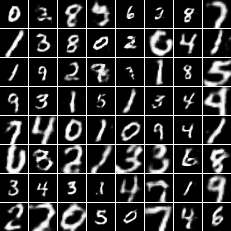

Target mask:


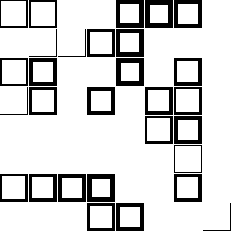

[     841 Epoch:[ 0/25] [  41/1093] time: 21.4777, d_loss: 1.48923278, g_loss: 2.23059368, walk_loss: 2.23059368
Target image:


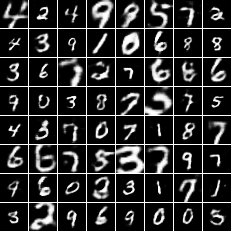

Target mask:


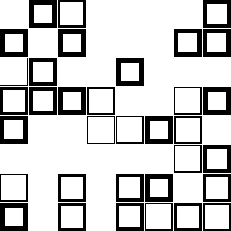

[     842 Epoch:[ 0/25] [  42/1093] time: 21.7723, d_loss: 1.50992048, g_loss: 2.20614457, walk_loss: 2.20614457
Target image:


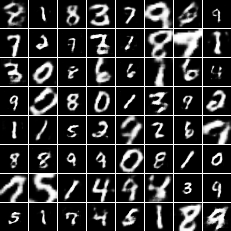

Target mask:


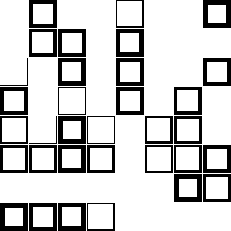

[     843 Epoch:[ 0/25] [  43/1093] time: 22.0598, d_loss: 1.48071623, g_loss: 2.20633698, walk_loss: 2.20633698
Target image:


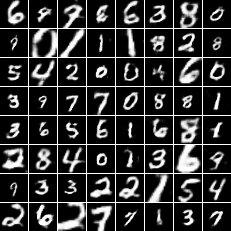

Target mask:


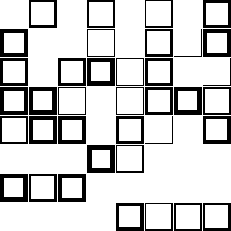

[     844 Epoch:[ 0/25] [  44/1093] time: 22.3510, d_loss: 1.49553716, g_loss: 2.16715479, walk_loss: 2.16715479
Target image:


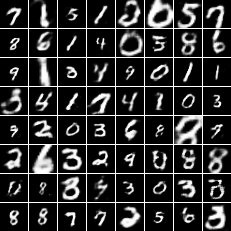

Target mask:


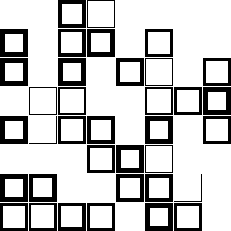

[     845 Epoch:[ 0/25] [  45/1093] time: 22.6157, d_loss: 1.49073124, g_loss: 2.20518398, walk_loss: 2.20518446
Target image:


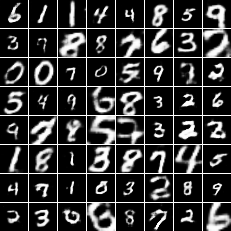

Target mask:


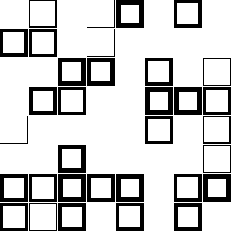

[     846 Epoch:[ 0/25] [  46/1093] time: 22.8757, d_loss: 1.49502397, g_loss: 2.20921993, walk_loss: 2.20921993
Target image:


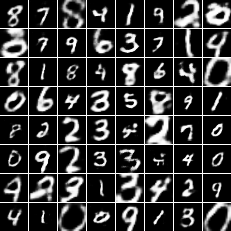

Target mask:


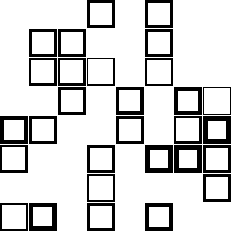

[     847 Epoch:[ 0/25] [  47/1093] time: 23.1755, d_loss: 1.49093843, g_loss: 2.20688200, walk_loss: 2.20688224
Target image:


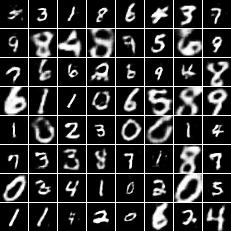

Target mask:


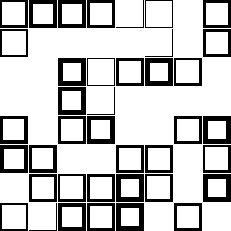

[     848 Epoch:[ 0/25] [  48/1093] time: 23.4699, d_loss: 1.49977028, g_loss: 2.19201756, walk_loss: 2.19201756
Target image:


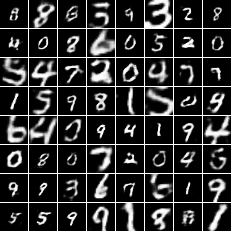

Target mask:


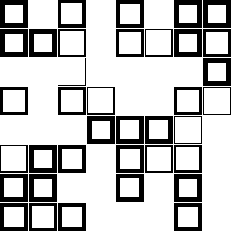

[     849 Epoch:[ 0/25] [  49/1093] time: 23.7678, d_loss: 1.49161708, g_loss: 2.20020509, walk_loss: 2.20020485
Target image:


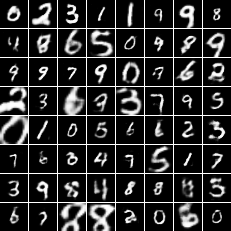

Target mask:


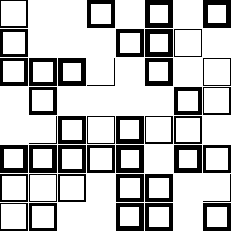

[     850 Epoch:[ 0/25] [  50/1093] time: 24.0497, d_loss: 1.49331617, g_loss: 2.19900846, walk_loss: 2.19900846
Target image:


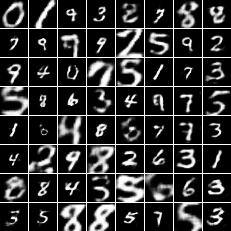

Target mask:


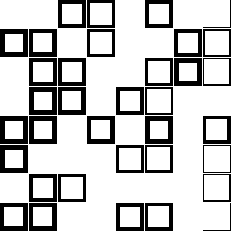

[     851 Epoch:[ 0/25] [  51/1093] time: 24.3452, d_loss: 1.49839628, g_loss: 2.21225476, walk_loss: 2.21225476
Target image:


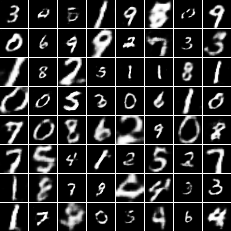

Target mask:


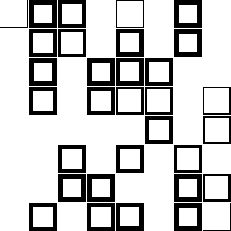

[     852 Epoch:[ 0/25] [  52/1093] time: 24.6317, d_loss: 1.49034417, g_loss: 2.19259477, walk_loss: 2.19259477
Target image:


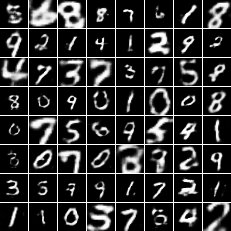

Target mask:


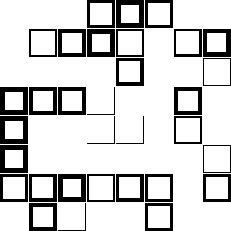

[     853 Epoch:[ 0/25] [  53/1093] time: 24.8640, d_loss: 1.48297167, g_loss: 2.20164156, walk_loss: 2.20164156
Target image:


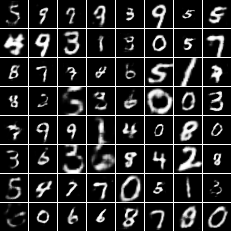

Target mask:


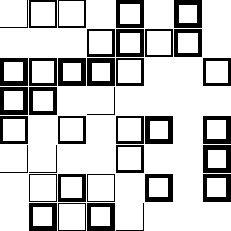

[     854 Epoch:[ 0/25] [  54/1093] time: 25.1088, d_loss: 1.48920298, g_loss: 2.19384193, walk_loss: 2.19384193
Target image:


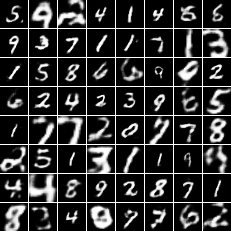

Target mask:


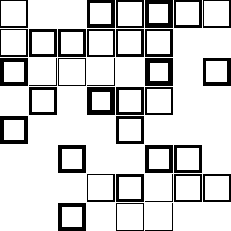

[     855 Epoch:[ 0/25] [  55/1093] time: 25.3548, d_loss: 1.50931501, g_loss: 2.17952013, walk_loss: 2.17952013
Target image:


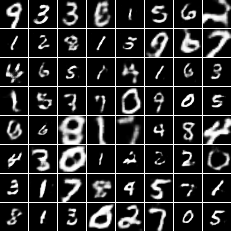

Target mask:


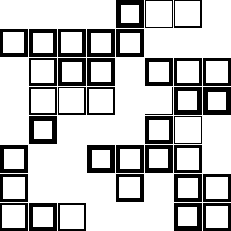

[     856 Epoch:[ 0/25] [  56/1093] time: 25.6482, d_loss: 1.49367809, g_loss: 2.19461513, walk_loss: 2.19461513
Target image:


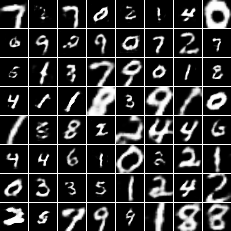

Target mask:


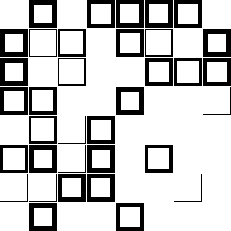

[     857 Epoch:[ 0/25] [  57/1093] time: 25.9502, d_loss: 1.49746132, g_loss: 2.21234345, walk_loss: 2.21234345
Target image:


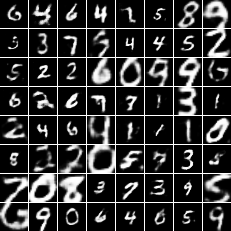

Target mask:


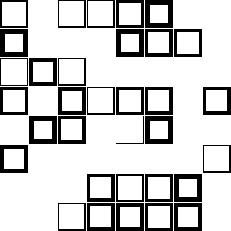

[     858 Epoch:[ 0/25] [  58/1093] time: 26.2536, d_loss: 1.49762154, g_loss: 2.21394801, walk_loss: 2.21394801
Target image:


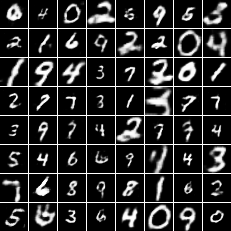

Target mask:


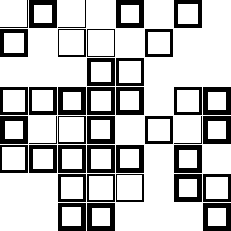

[     859 Epoch:[ 0/25] [  59/1093] time: 26.5612, d_loss: 1.47827768, g_loss: 2.20555401, walk_loss: 2.20555401
Target image:


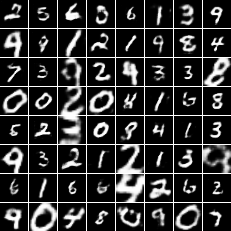

Target mask:


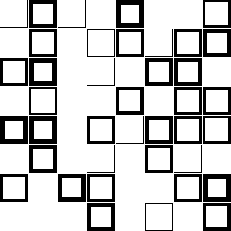

[     860 Epoch:[ 0/25] [  60/1093] time: 26.8954, d_loss: 1.48664784, g_loss: 2.20990872, walk_loss: 2.20990872
Target image:


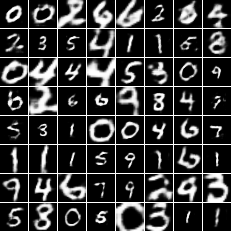

Target mask:


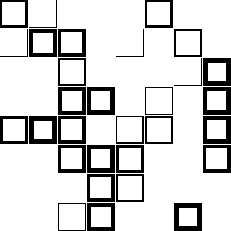

[     861 Epoch:[ 0/25] [  61/1093] time: 27.2062, d_loss: 1.49100435, g_loss: 2.22220325, walk_loss: 2.22220325
Target image:


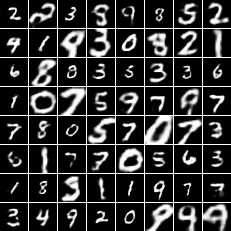

Target mask:


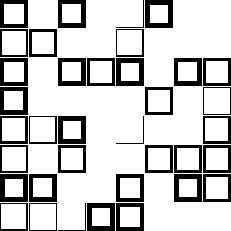

[     862 Epoch:[ 0/25] [  62/1093] time: 27.5256, d_loss: 1.49940753, g_loss: 2.19229317, walk_loss: 2.19229317
Target image:


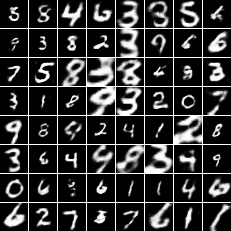

Target mask:


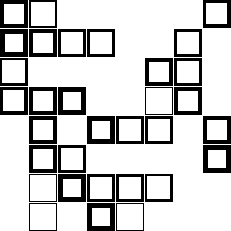

[     863 Epoch:[ 0/25] [  63/1093] time: 27.8637, d_loss: 1.49854267, g_loss: 2.20042896, walk_loss: 2.20042896
Target image:


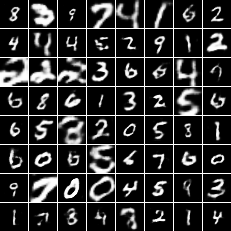

Target mask:


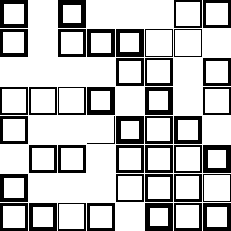

[     864 Epoch:[ 0/25] [  64/1093] time: 28.1737, d_loss: 1.48680413, g_loss: 2.20835328, walk_loss: 2.20835352
Target image:


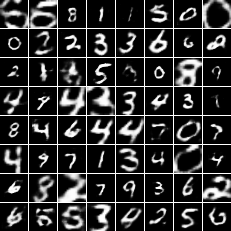

Target mask:


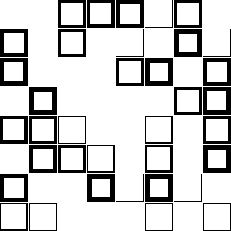

[     865 Epoch:[ 0/25] [  65/1093] time: 28.4814, d_loss: 1.47985327, g_loss: 2.21692443, walk_loss: 2.21692443
Target image:


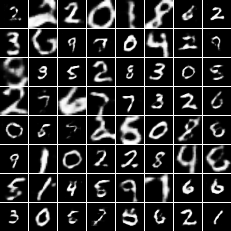

Target mask:


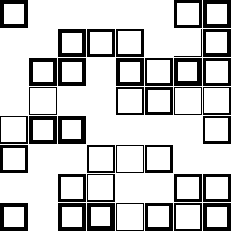

[     866 Epoch:[ 0/25] [  66/1093] time: 28.7853, d_loss: 1.48882675, g_loss: 2.22674417, walk_loss: 2.22674417
Target image:


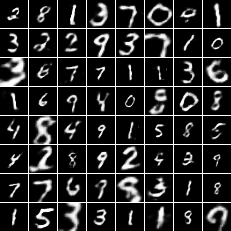

Target mask:


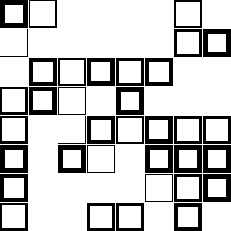

[     867 Epoch:[ 0/25] [  67/1093] time: 29.1135, d_loss: 1.49445379, g_loss: 2.19276977, walk_loss: 2.19276977
Target image:


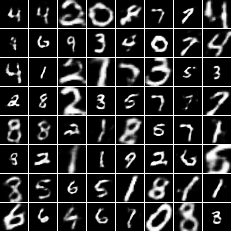

Target mask:


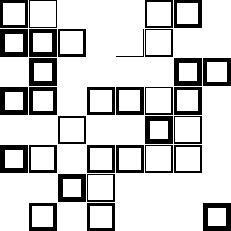

[     868 Epoch:[ 0/25] [  68/1093] time: 29.4112, d_loss: 1.49632215, g_loss: 2.19026041, walk_loss: 2.19026041
Target image:


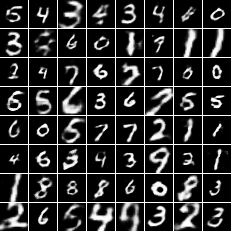

Target mask:


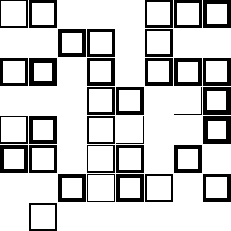

[     869 Epoch:[ 0/25] [  69/1093] time: 29.7509, d_loss: 1.48157430, g_loss: 2.19600940, walk_loss: 2.19600964
Target image:


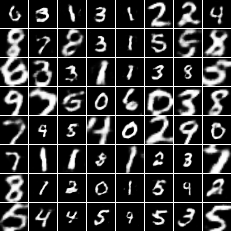

Target mask:


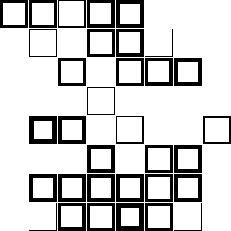

[     870 Epoch:[ 0/25] [  70/1093] time: 30.0577, d_loss: 1.49754596, g_loss: 2.19431615, walk_loss: 2.19431615
Target image:


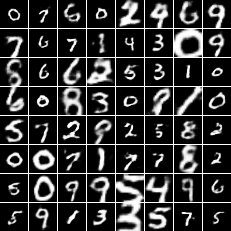

Target mask:


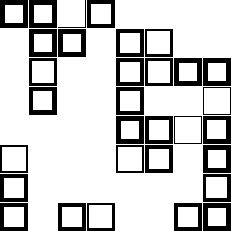

[     871 Epoch:[ 0/25] [  71/1093] time: 30.3601, d_loss: 1.48413634, g_loss: 2.23122621, walk_loss: 2.23122644
Target image:


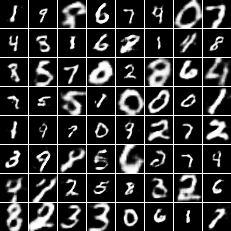

Target mask:


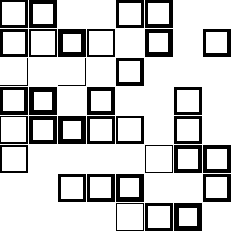

[     872 Epoch:[ 0/25] [  72/1093] time: 30.6312, d_loss: 1.47582972, g_loss: 2.21142983, walk_loss: 2.21143007
Target image:


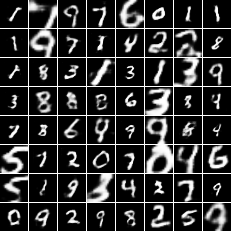

Target mask:


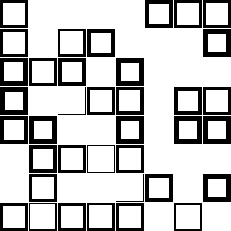

[     873 Epoch:[ 0/25] [  73/1093] time: 30.9228, d_loss: 1.48344743, g_loss: 2.19716549, walk_loss: 2.19716549
Target image:


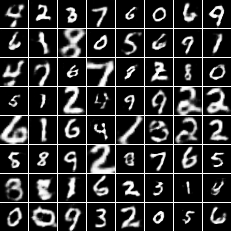

Target mask:


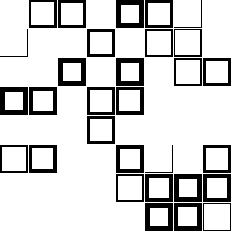

[     874 Epoch:[ 0/25] [  74/1093] time: 31.2231, d_loss: 1.49629056, g_loss: 2.16732216, walk_loss: 2.16732216
Target image:


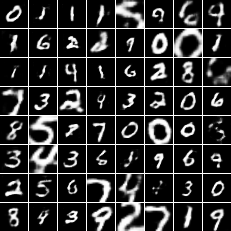

Target mask:


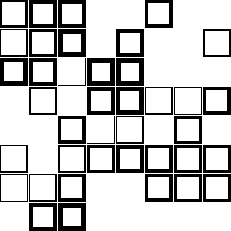

[     875 Epoch:[ 0/25] [  75/1093] time: 31.5263, d_loss: 1.49040246, g_loss: 2.20598984, walk_loss: 2.20598984
Target image:


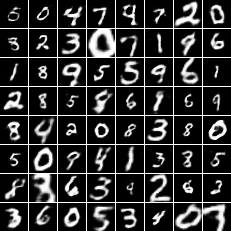

Target mask:


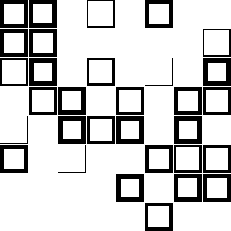

[     876 Epoch:[ 0/25] [  76/1093] time: 31.8007, d_loss: 1.48986435, g_loss: 2.17830801, walk_loss: 2.17830801
Target image:


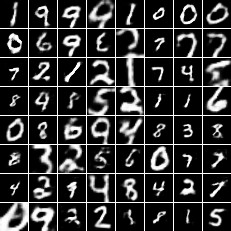

Target mask:


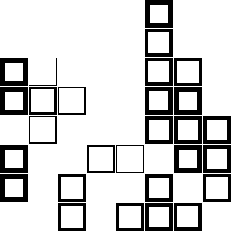

[     877 Epoch:[ 0/25] [  77/1093] time: 32.0766, d_loss: 1.48482466, g_loss: 2.20263171, walk_loss: 2.20263171
Target image:


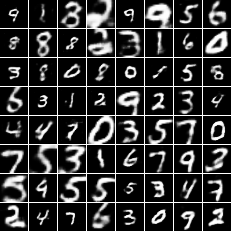

Target mask:


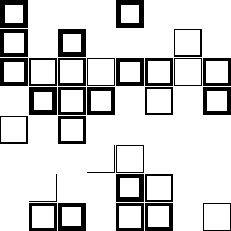

[     878 Epoch:[ 0/25] [  78/1093] time: 32.3744, d_loss: 1.49147356, g_loss: 2.19768167, walk_loss: 2.19768167
Target image:


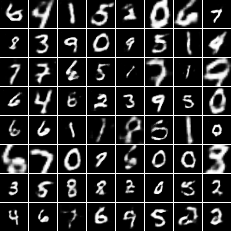

Target mask:


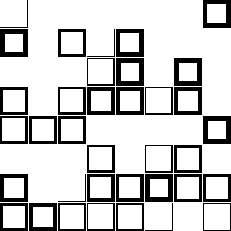

[     879 Epoch:[ 0/25] [  79/1093] time: 32.7080, d_loss: 1.51038897, g_loss: 2.19029975, walk_loss: 2.19029975
Target image:


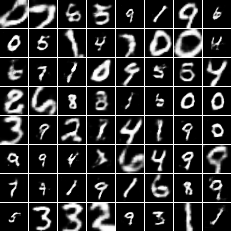

Target mask:


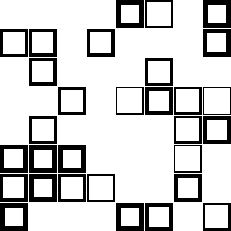

[     880 Epoch:[ 0/25] [  80/1093] time: 32.9889, d_loss: 1.48487186, g_loss: 2.21122146, walk_loss: 2.21122146
Target image:


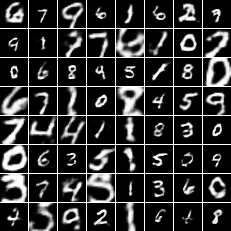

Target mask:


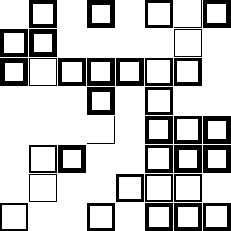

[     881 Epoch:[ 0/25] [  81/1093] time: 33.2850, d_loss: 1.50094175, g_loss: 2.20361567, walk_loss: 2.20361567
Target image:


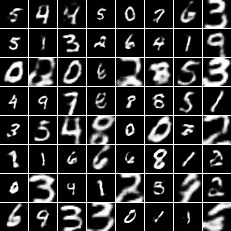

Target mask:


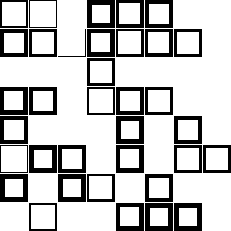

[     882 Epoch:[ 0/25] [  82/1093] time: 33.5715, d_loss: 1.49136567, g_loss: 2.24607396, walk_loss: 2.24607372
Target image:


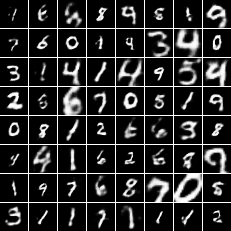

Target mask:


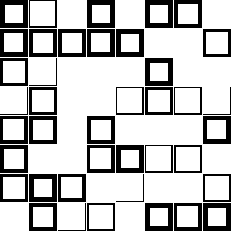

[     883 Epoch:[ 0/25] [  83/1093] time: 33.8694, d_loss: 1.50544119, g_loss: 2.21371555, walk_loss: 2.21371555
Target image:


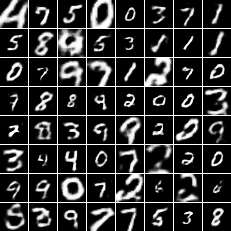

Target mask:


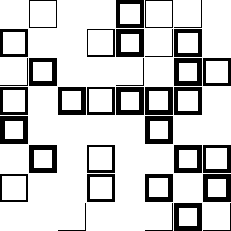

[     884 Epoch:[ 0/25] [  84/1093] time: 34.1559, d_loss: 1.49986517, g_loss: 2.20557904, walk_loss: 2.20557904
Target image:


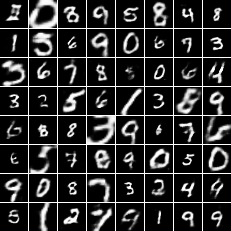

Target mask:


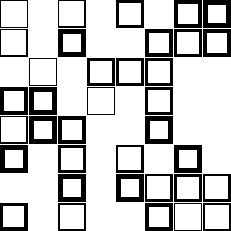

[     885 Epoch:[ 0/25] [  85/1093] time: 34.4270, d_loss: 1.48699069, g_loss: 2.19667482, walk_loss: 2.19667482
Target image:


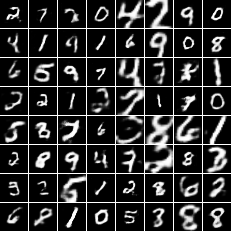

Target mask:


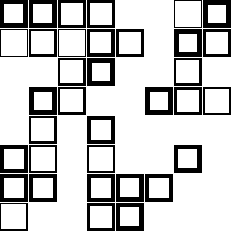

[     886 Epoch:[ 0/25] [  86/1093] time: 34.6989, d_loss: 1.47935295, g_loss: 2.19343066, walk_loss: 2.19343066
Target image:


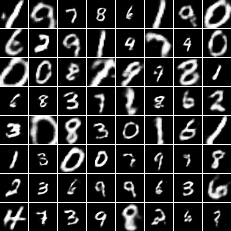

Target mask:


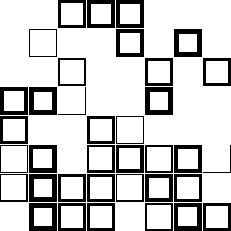

[     887 Epoch:[ 0/25] [  87/1093] time: 34.9641, d_loss: 1.48660862, g_loss: 2.19277096, walk_loss: 2.19277096
Target image:


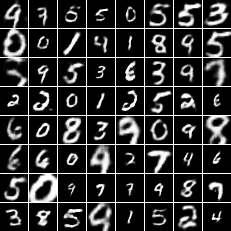

Target mask:


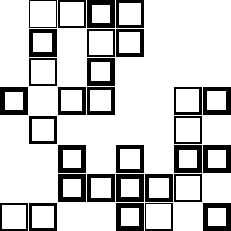

[     888 Epoch:[ 0/25] [  88/1093] time: 35.2557, d_loss: 1.49115598, g_loss: 2.20060968, walk_loss: 2.20060968
Target image:


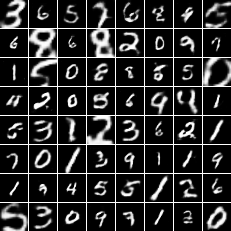

Target mask:


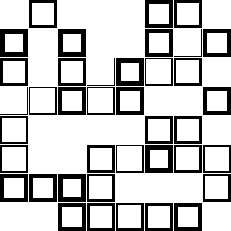

[     889 Epoch:[ 0/25] [  89/1093] time: 35.5100, d_loss: 1.48331785, g_loss: 2.20965528, walk_loss: 2.20965528
Target image:


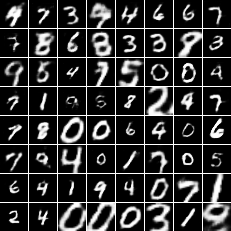

Target mask:


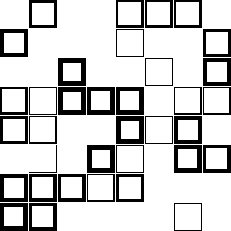

[     890 Epoch:[ 0/25] [  90/1093] time: 35.7597, d_loss: 1.48145151, g_loss: 2.19580078, walk_loss: 2.19580078
Target image:


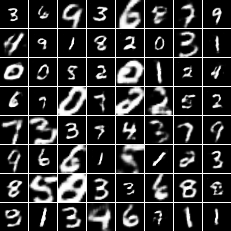

Target mask:


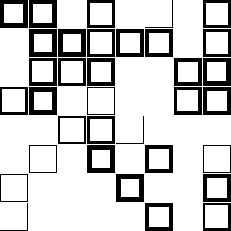

[     891 Epoch:[ 0/25] [  91/1093] time: 35.9998, d_loss: 1.48449516, g_loss: 2.20792723, walk_loss: 2.20792723
Target image:


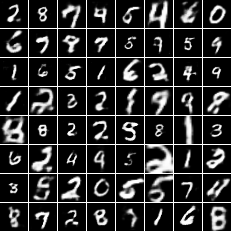

Target mask:


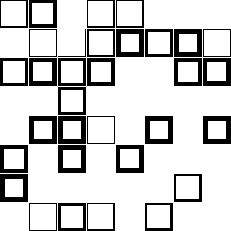

[     892 Epoch:[ 0/25] [  92/1093] time: 36.2606, d_loss: 1.50387824, g_loss: 2.18974185, walk_loss: 2.18974185
Target image:


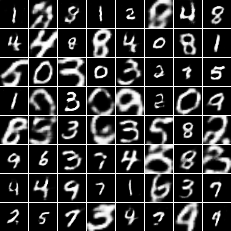

Target mask:


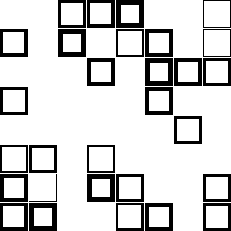

[     893 Epoch:[ 0/25] [  93/1093] time: 36.5398, d_loss: 1.49207354, g_loss: 2.23915815, walk_loss: 2.23915815
Target image:


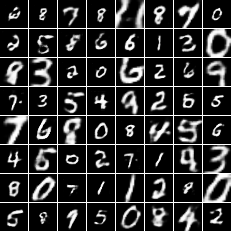

Target mask:


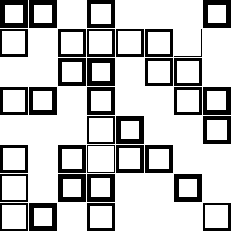

[     894 Epoch:[ 0/25] [  94/1093] time: 36.8340, d_loss: 1.48506272, g_loss: 2.22624016, walk_loss: 2.22624016
Target image:


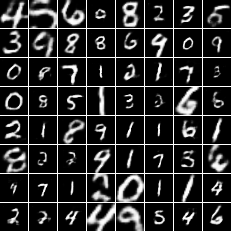

Target mask:


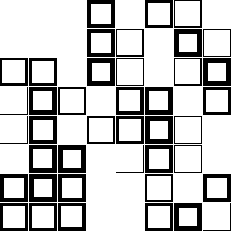

[     895 Epoch:[ 0/25] [  95/1093] time: 37.1143, d_loss: 1.50099277, g_loss: 2.20778966, walk_loss: 2.20778966
Target image:


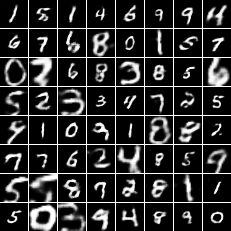

Target mask:


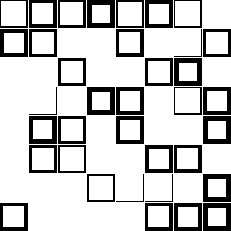

[     896 Epoch:[ 0/25] [  96/1093] time: 37.3909, d_loss: 1.49719667, g_loss: 2.21821547, walk_loss: 2.21821547
Target image:


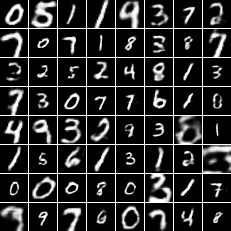

Target mask:


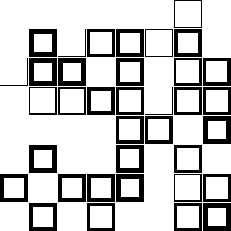

[     897 Epoch:[ 0/25] [  97/1093] time: 37.6434, d_loss: 1.47590089, g_loss: 2.22688365, walk_loss: 2.22688365
Target image:


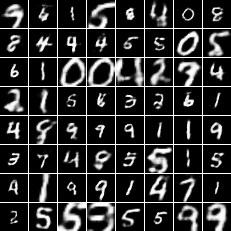

Target mask:


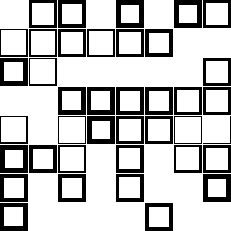

[     898 Epoch:[ 0/25] [  98/1093] time: 37.8913, d_loss: 1.47797513, g_loss: 2.23151827, walk_loss: 2.23151827
Target image:


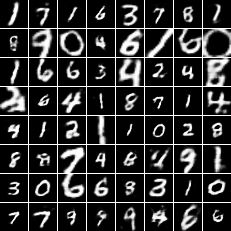

Target mask:


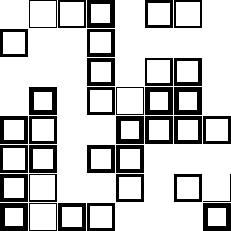

[     899 Epoch:[ 0/25] [  99/1093] time: 38.1701, d_loss: 1.47031713, g_loss: 2.22048831, walk_loss: 2.22048831
Target image:


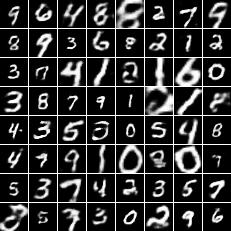

Target mask:


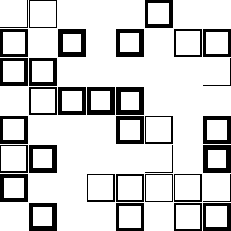

[     900 Epoch:[ 0/25] [ 100/1093] time: 38.4426, d_loss: 1.50295472, g_loss: 2.17600608, walk_loss: 2.17600608
Target image:


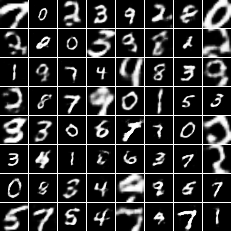

Target mask:


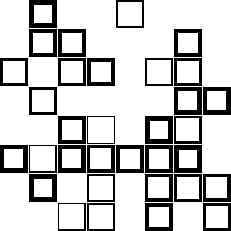

[     901 Epoch:[ 0/25] [ 101/1093] time: 38.6901, d_loss: 1.49094725, g_loss: 2.22859383, walk_loss: 2.22859406
Target image:


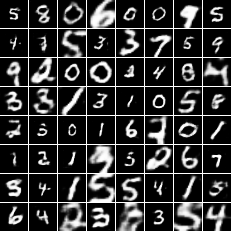

Target mask:


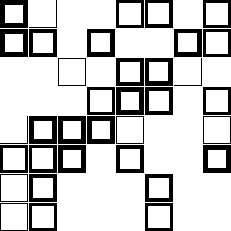

[     902 Epoch:[ 0/25] [ 102/1093] time: 38.9317, d_loss: 1.49993086, g_loss: 2.20401073, walk_loss: 2.20401073
Target image:


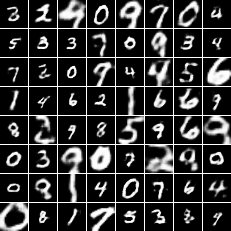

Target mask:


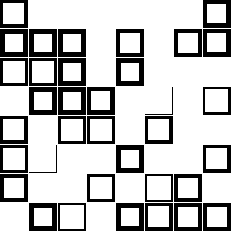

[     903 Epoch:[ 0/25] [ 103/1093] time: 39.2293, d_loss: 1.49304366, g_loss: 2.19959164, walk_loss: 2.19959164
Target image:


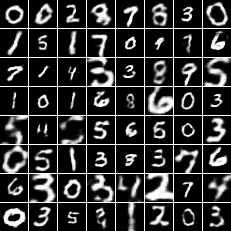

Target mask:


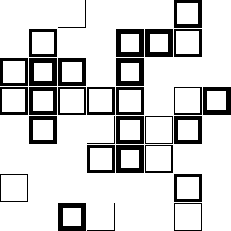

[     904 Epoch:[ 0/25] [ 104/1093] time: 39.4986, d_loss: 1.48884749, g_loss: 2.19219112, walk_loss: 2.19219112
Target image:


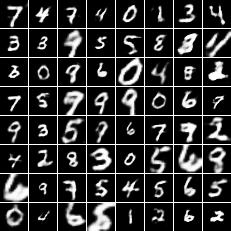

Target mask:


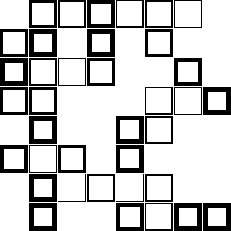

[     905 Epoch:[ 0/25] [ 105/1093] time: 39.7302, d_loss: 1.48711801, g_loss: 2.19325900, walk_loss: 2.19325900
Target image:


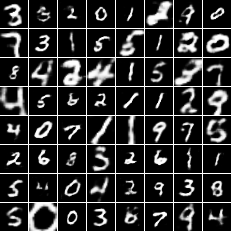

Target mask:


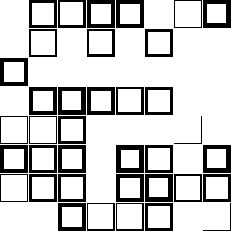

[     906 Epoch:[ 0/25] [ 106/1093] time: 39.9889, d_loss: 1.49963069, g_loss: 2.20349312, walk_loss: 2.20349312
Target image:


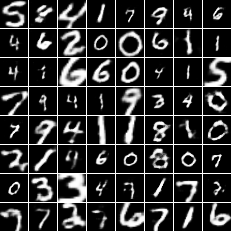

Target mask:


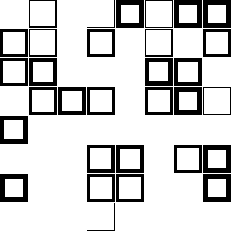

[     907 Epoch:[ 0/25] [ 107/1093] time: 40.2662, d_loss: 1.50084949, g_loss: 2.20621204, walk_loss: 2.20621204
Target image:


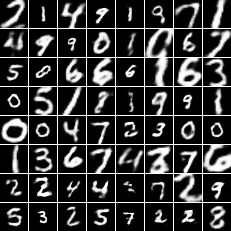

Target mask:


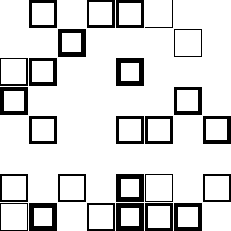

[     908 Epoch:[ 0/25] [ 108/1093] time: 40.5464, d_loss: 1.49628615, g_loss: 2.20164013, walk_loss: 2.20164037
Target image:


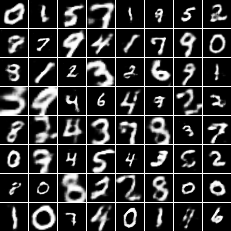

Target mask:


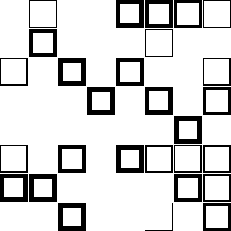

[     909 Epoch:[ 0/25] [ 109/1093] time: 40.8506, d_loss: 1.49468768, g_loss: 2.18753195, walk_loss: 2.18753195
Target image:


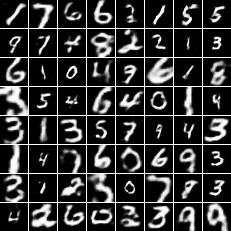

Target mask:


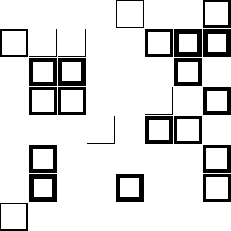

[     910 Epoch:[ 0/25] [ 110/1093] time: 41.1082, d_loss: 1.48771703, g_loss: 2.20470405, walk_loss: 2.20470428
Target image:


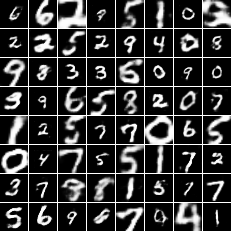

Target mask:


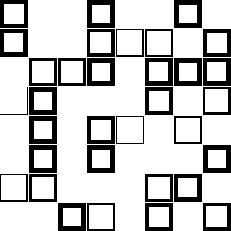

[     911 Epoch:[ 0/25] [ 111/1093] time: 41.3852, d_loss: 1.49099636, g_loss: 2.21334028, walk_loss: 2.21334028
Target image:


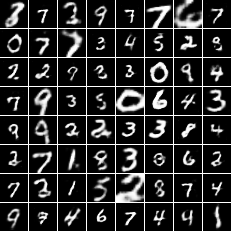

Target mask:


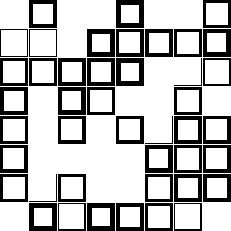

[     912 Epoch:[ 0/25] [ 112/1093] time: 41.6556, d_loss: 1.49277282, g_loss: 2.20154834, walk_loss: 2.20154834
Target image:


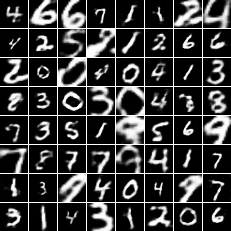

Target mask:


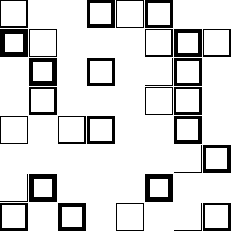

[     913 Epoch:[ 0/25] [ 113/1093] time: 41.9639, d_loss: 1.48766327, g_loss: 2.23713827, walk_loss: 2.23713827
Target image:


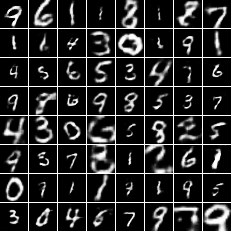

Target mask:


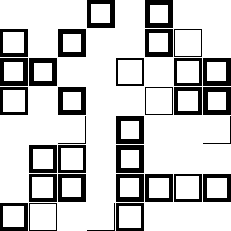

[     914 Epoch:[ 0/25] [ 114/1093] time: 42.2626, d_loss: 1.50843430, g_loss: 2.18962383, walk_loss: 2.18962359
Target image:


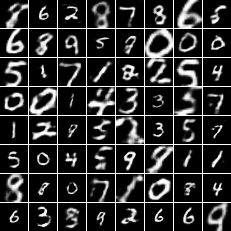

Target mask:


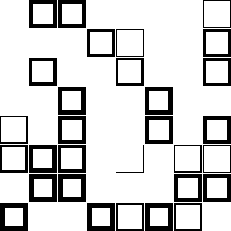

[     915 Epoch:[ 0/25] [ 115/1093] time: 42.5985, d_loss: 1.50307965, g_loss: 2.22313762, walk_loss: 2.22313762
Target image:


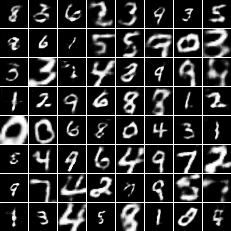

Target mask:


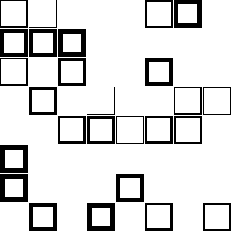

[     916 Epoch:[ 0/25] [ 116/1093] time: 42.8930, d_loss: 1.50162649, g_loss: 2.20062613, walk_loss: 2.20062613
Target image:


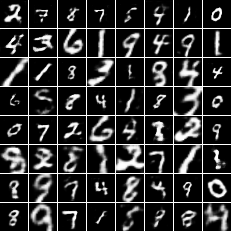

Target mask:


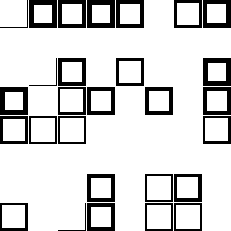

[     917 Epoch:[ 0/25] [ 117/1093] time: 43.1821, d_loss: 1.49539423, g_loss: 2.19745922, walk_loss: 2.19745922
Target image:


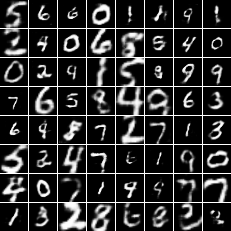

Target mask:


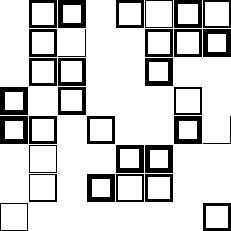

[     918 Epoch:[ 0/25] [ 118/1093] time: 43.4512, d_loss: 1.49238443, g_loss: 2.20348167, walk_loss: 2.20348167
Target image:


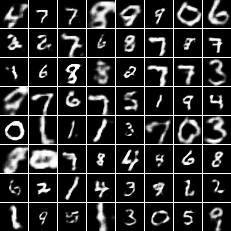

Target mask:


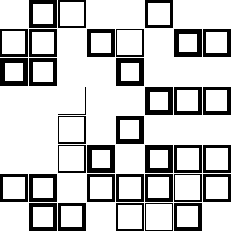

[     919 Epoch:[ 0/25] [ 119/1093] time: 43.7497, d_loss: 1.49124527, g_loss: 2.20786023, walk_loss: 2.20786047
Target image:


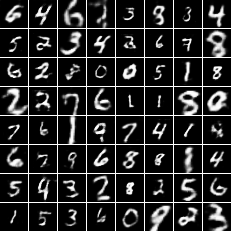

Target mask:


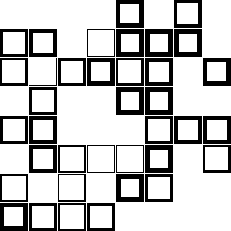

[     920 Epoch:[ 0/25] [ 120/1093] time: 44.0542, d_loss: 1.48850870, g_loss: 2.18678856, walk_loss: 2.18678856
Target image:


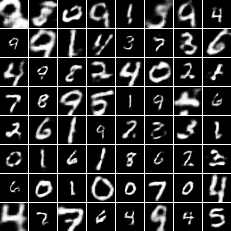

Target mask:


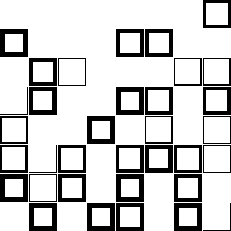

[     921 Epoch:[ 0/25] [ 121/1093] time: 44.3579, d_loss: 1.49760354, g_loss: 2.18212724, walk_loss: 2.18212724
Target image:


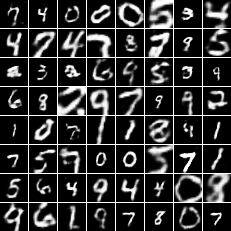

Target mask:


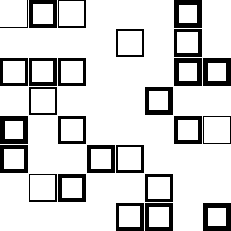

[     922 Epoch:[ 0/25] [ 122/1093] time: 44.6699, d_loss: 1.49318516, g_loss: 2.21034169, walk_loss: 2.21034169
Target image:


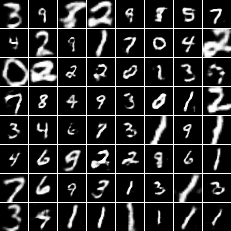

Target mask:


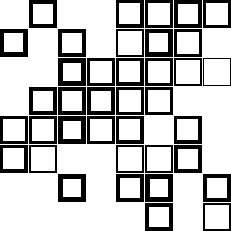

[     923 Epoch:[ 0/25] [ 123/1093] time: 44.9414, d_loss: 1.47430325, g_loss: 2.21276093, walk_loss: 2.21276069
Target image:


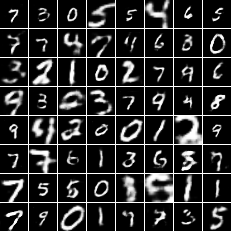

Target mask:


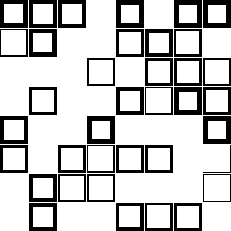

[     924 Epoch:[ 0/25] [ 124/1093] time: 45.2418, d_loss: 1.49676800, g_loss: 2.22374535, walk_loss: 2.22374535
Target image:


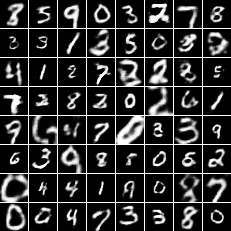

Target mask:


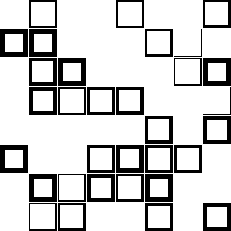

[     925 Epoch:[ 0/25] [ 125/1093] time: 45.5064, d_loss: 1.49078453, g_loss: 2.20190120, walk_loss: 2.20190144
Target image:


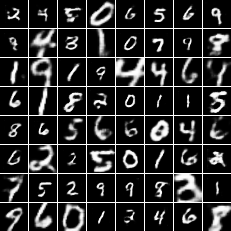

Target mask:


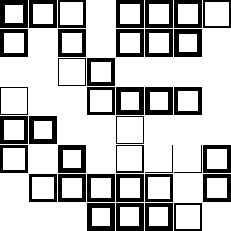

[     926 Epoch:[ 0/25] [ 126/1093] time: 45.7802, d_loss: 1.49000430, g_loss: 2.21199417, walk_loss: 2.21199417
Target image:


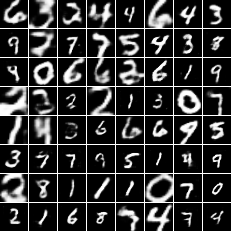

Target mask:


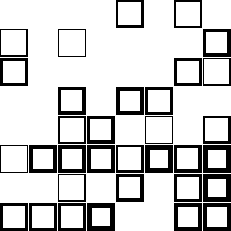

[     927 Epoch:[ 0/25] [ 127/1093] time: 46.0821, d_loss: 1.48721051, g_loss: 2.22381067, walk_loss: 2.22381091
Target image:


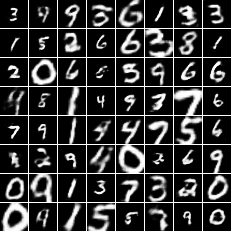

Target mask:


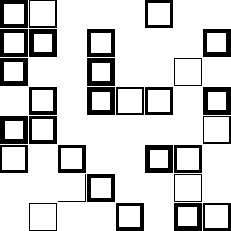

[     928 Epoch:[ 0/25] [ 128/1093] time: 46.3723, d_loss: 1.50713921, g_loss: 2.21001935, walk_loss: 2.21001935
Target image:


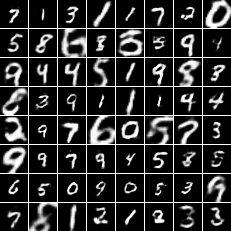

Target mask:


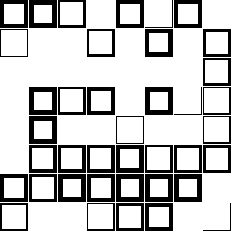

[     929 Epoch:[ 0/25] [ 129/1093] time: 46.6645, d_loss: 1.49394560, g_loss: 2.20777917, walk_loss: 2.20777917
Target image:


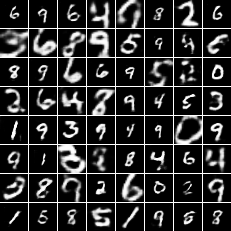

Target mask:


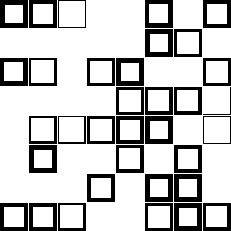

[     930 Epoch:[ 0/25] [ 130/1093] time: 46.9484, d_loss: 1.49596691, g_loss: 2.20121217, walk_loss: 2.20121217
Target image:


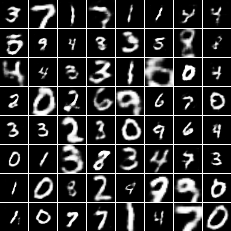

Target mask:


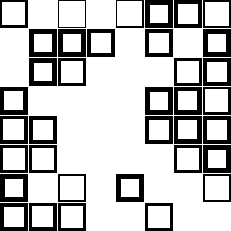

[     931 Epoch:[ 0/25] [ 131/1093] time: 47.2369, d_loss: 1.49613285, g_loss: 2.20522547, walk_loss: 2.20522547
Target image:


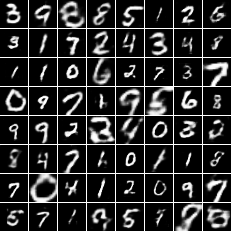

Target mask:


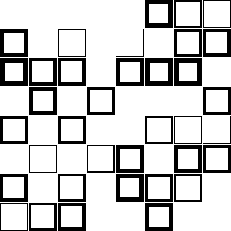

[     932 Epoch:[ 0/25] [ 132/1093] time: 47.4788, d_loss: 1.49326348, g_loss: 2.20825958, walk_loss: 2.20825958
Target image:


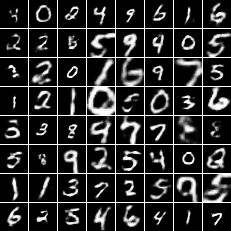

Target mask:


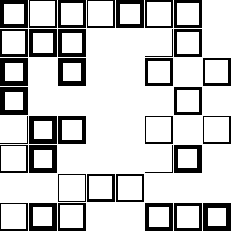

[     933 Epoch:[ 0/25] [ 133/1093] time: 47.7622, d_loss: 1.48925734, g_loss: 2.21685481, walk_loss: 2.21685481
Target image:


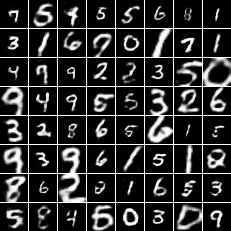

Target mask:


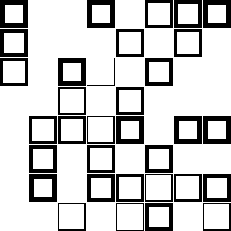

[     934 Epoch:[ 0/25] [ 134/1093] time: 48.0118, d_loss: 1.49343872, g_loss: 2.20877361, walk_loss: 2.20877361
Target image:


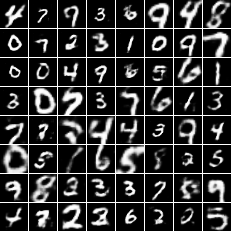

Target mask:


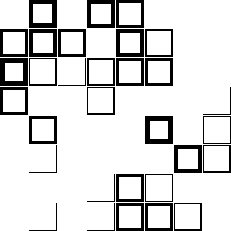

[     935 Epoch:[ 0/25] [ 135/1093] time: 48.3264, d_loss: 1.48484802, g_loss: 2.19440746, walk_loss: 2.19440746
Target image:


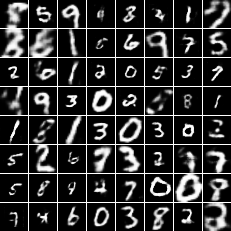

Target mask:


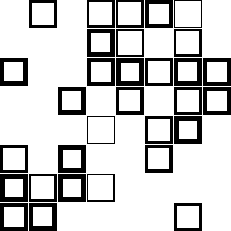

[     936 Epoch:[ 0/25] [ 136/1093] time: 48.6002, d_loss: 1.48214936, g_loss: 2.19531107, walk_loss: 2.19531107
Target image:


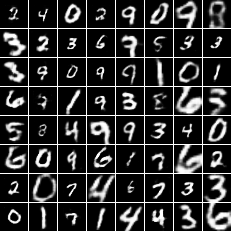

Target mask:


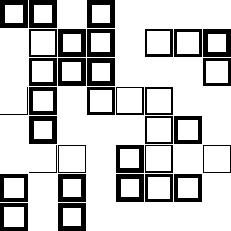

[     937 Epoch:[ 0/25] [ 137/1093] time: 48.8625, d_loss: 1.48483372, g_loss: 2.18759823, walk_loss: 2.18759823
Target image:


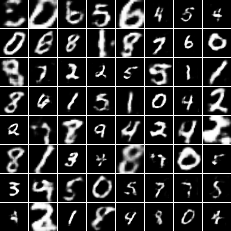

Target mask:


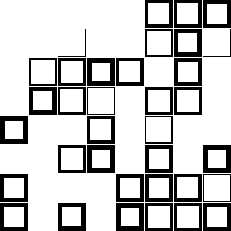

[     938 Epoch:[ 0/25] [ 138/1093] time: 49.1345, d_loss: 1.47795773, g_loss: 2.20444679, walk_loss: 2.20444679
Target image:


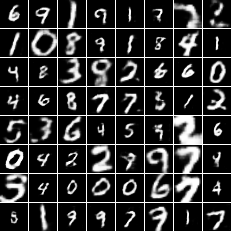

Target mask:


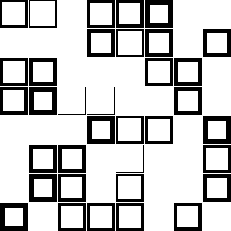

[     939 Epoch:[ 0/25] [ 139/1093] time: 49.4583, d_loss: 1.49107313, g_loss: 2.20208168, walk_loss: 2.20208168
Target image:


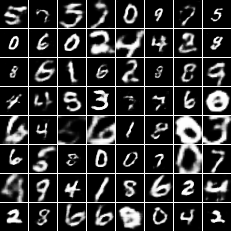

Target mask:


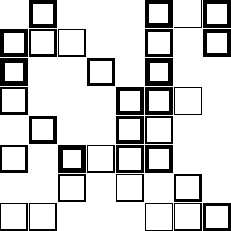

[     940 Epoch:[ 0/25] [ 140/1093] time: 49.6963, d_loss: 1.49364936, g_loss: 2.17927432, walk_loss: 2.17927432
Target image:


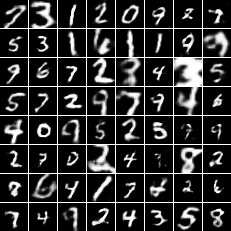

Target mask:


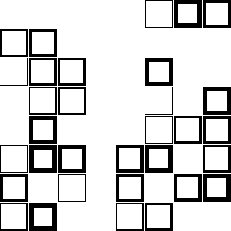

[     941 Epoch:[ 0/25] [ 141/1093] time: 49.9633, d_loss: 1.48418188, g_loss: 2.18147206, walk_loss: 2.18147206
Target image:


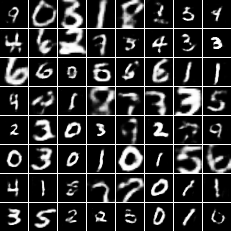

Target mask:


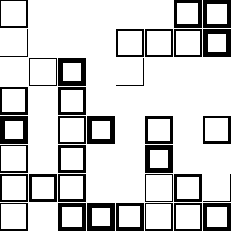

[     942 Epoch:[ 0/25] [ 142/1093] time: 50.2131, d_loss: 1.49604011, g_loss: 2.19420481, walk_loss: 2.19420481
Target image:


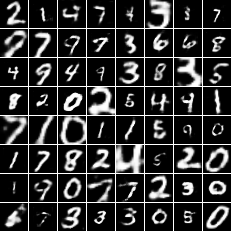

Target mask:


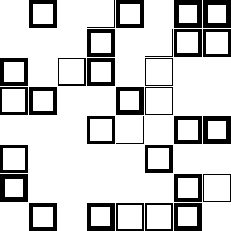

[     943 Epoch:[ 0/25] [ 143/1093] time: 50.4564, d_loss: 1.49744534, g_loss: 2.17563391, walk_loss: 2.17563415
Target image:


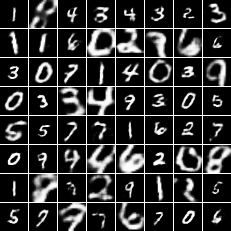

Target mask:


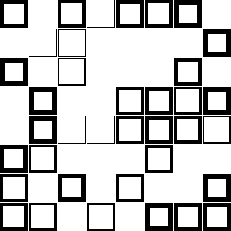

[     944 Epoch:[ 0/25] [ 144/1093] time: 50.7257, d_loss: 1.48598254, g_loss: 2.24128008, walk_loss: 2.24128008
Target image:


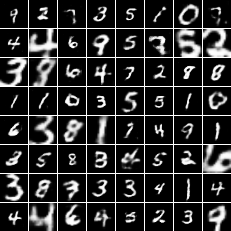

Target mask:


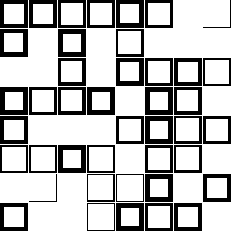

[     945 Epoch:[ 0/25] [ 145/1093] time: 50.9896, d_loss: 1.50850844, g_loss: 2.21122360, walk_loss: 2.21122360
Target image:


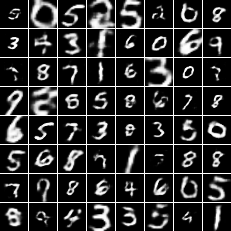

Target mask:


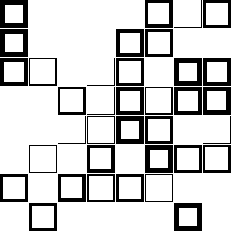

[     946 Epoch:[ 0/25] [ 146/1093] time: 51.2933, d_loss: 1.48335910, g_loss: 2.22648573, walk_loss: 2.22648573
Target image:


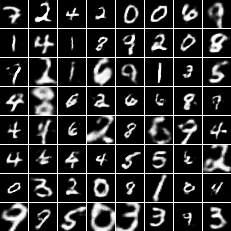

Target mask:


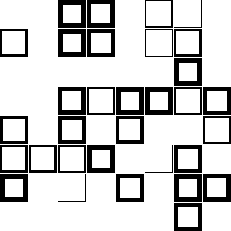

[     947 Epoch:[ 0/25] [ 147/1093] time: 51.5560, d_loss: 1.50717998, g_loss: 2.19927764, walk_loss: 2.19927788
Target image:


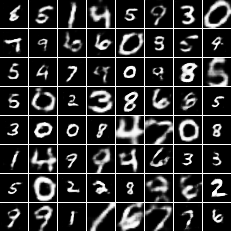

Target mask:


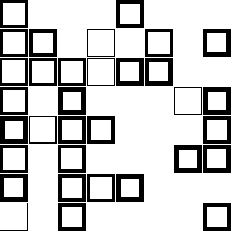

[     948 Epoch:[ 0/25] [ 148/1093] time: 51.8069, d_loss: 1.48913968, g_loss: 2.18932033, walk_loss: 2.18932056
Target image:


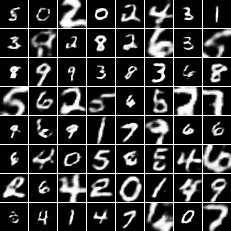

Target mask:


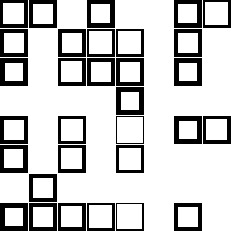

[     949 Epoch:[ 0/25] [ 149/1093] time: 52.0724, d_loss: 1.50737619, g_loss: 2.21080375, walk_loss: 2.21080375
Target image:


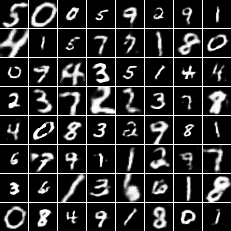

Target mask:


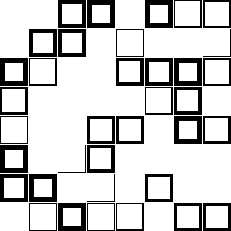

[     950 Epoch:[ 0/25] [ 150/1093] time: 52.3401, d_loss: 1.49658704, g_loss: 2.18788266, walk_loss: 2.18788242
Target image:


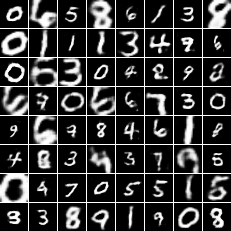

Target mask:


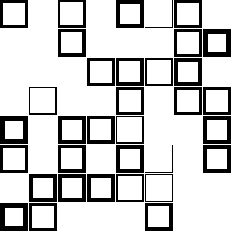

[     951 Epoch:[ 0/25] [ 151/1093] time: 52.6151, d_loss: 1.48277867, g_loss: 2.22721934, walk_loss: 2.22721934
Target image:


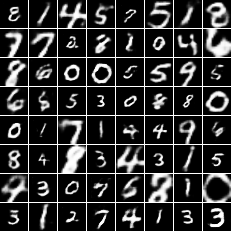

Target mask:


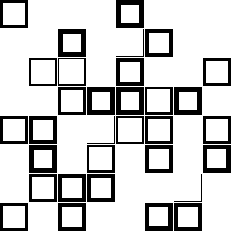

[     952 Epoch:[ 0/25] [ 152/1093] time: 52.8858, d_loss: 1.49160707, g_loss: 2.21376061, walk_loss: 2.21376061
Target image:


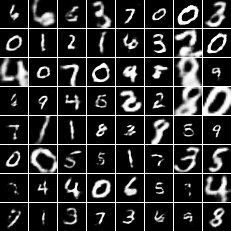

Target mask:


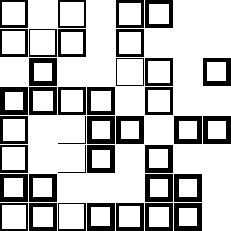

[     953 Epoch:[ 0/25] [ 153/1093] time: 53.2098, d_loss: 1.48220658, g_loss: 2.21062088, walk_loss: 2.21062088
Target image:


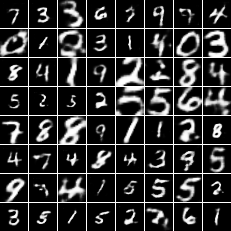

Target mask:


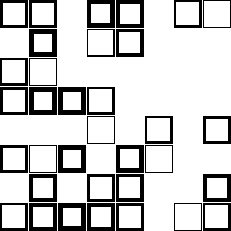

[     954 Epoch:[ 0/25] [ 154/1093] time: 53.5087, d_loss: 1.49304748, g_loss: 2.20024776, walk_loss: 2.20024776
Target image:


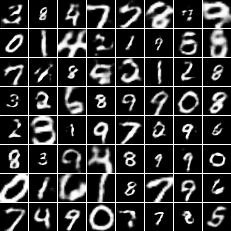

Target mask:


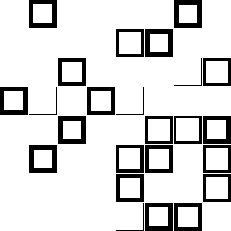

[     955 Epoch:[ 0/25] [ 155/1093] time: 53.8139, d_loss: 1.48366570, g_loss: 2.19832349, walk_loss: 2.19832349
Target image:


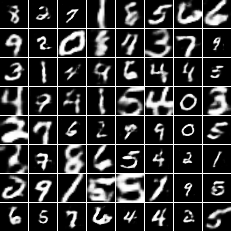

Target mask:


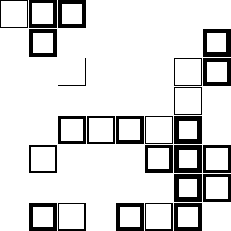

[     956 Epoch:[ 0/25] [ 156/1093] time: 54.1313, d_loss: 1.48376322, g_loss: 2.21240067, walk_loss: 2.21240044
Target image:


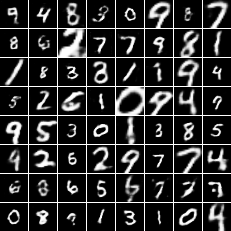

Target mask:


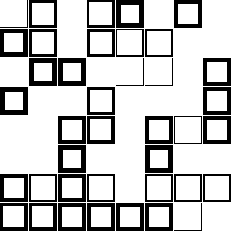

[     957 Epoch:[ 0/25] [ 157/1093] time: 54.3983, d_loss: 1.49272561, g_loss: 2.19753838, walk_loss: 2.19753838
Target image:


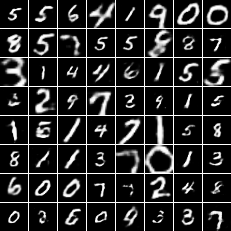

Target mask:


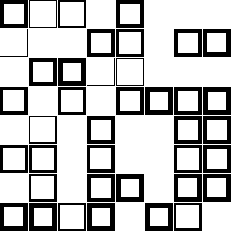

[     958 Epoch:[ 0/25] [ 158/1093] time: 54.6917, d_loss: 1.49055862, g_loss: 2.20316577, walk_loss: 2.20316577
Target image:


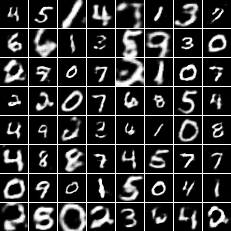

Target mask:


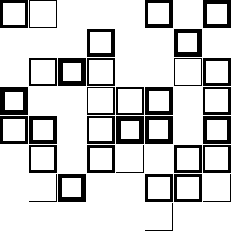

[     959 Epoch:[ 0/25] [ 159/1093] time: 54.9841, d_loss: 1.49493444, g_loss: 2.20613718, walk_loss: 2.20613718
Target image:


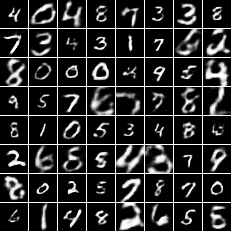

Target mask:


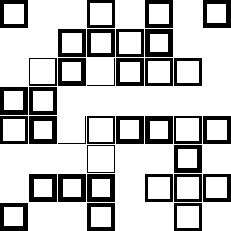

[     960 Epoch:[ 0/25] [ 160/1093] time: 55.2705, d_loss: 1.49822807, g_loss: 2.21802235, walk_loss: 2.21802235
Target image:


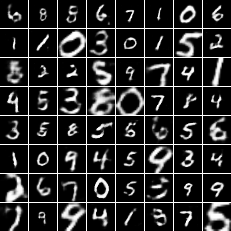

Target mask:


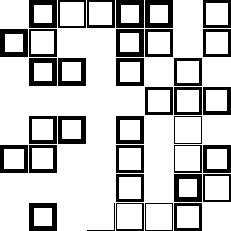

[     961 Epoch:[ 0/25] [ 161/1093] time: 55.5175, d_loss: 1.49397981, g_loss: 2.21317053, walk_loss: 2.21317029
Target image:


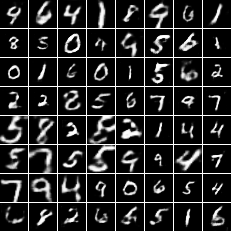

Target mask:


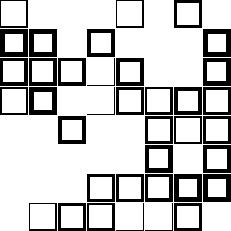

[     962 Epoch:[ 0/25] [ 162/1093] time: 55.7871, d_loss: 1.49585688, g_loss: 2.19001555, walk_loss: 2.19001555
Target image:


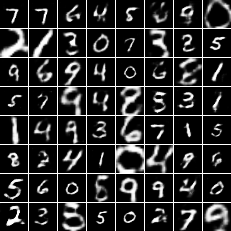

Target mask:


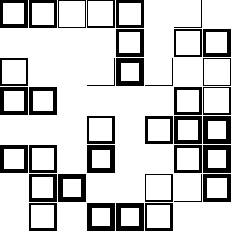

[     963 Epoch:[ 0/25] [ 163/1093] time: 56.0367, d_loss: 1.48829412, g_loss: 2.20399594, walk_loss: 2.20399594
Target image:


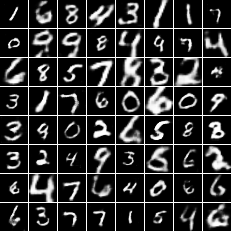

Target mask:


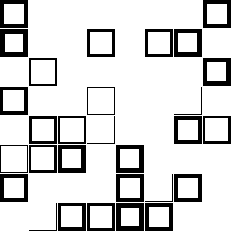

[     964 Epoch:[ 0/25] [ 164/1093] time: 56.2884, d_loss: 1.47690427, g_loss: 2.20985436, walk_loss: 2.20985436
Target image:


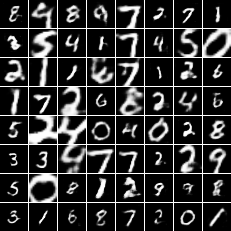

Target mask:


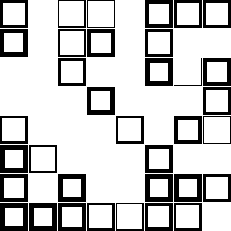

[     965 Epoch:[ 0/25] [ 165/1093] time: 56.5439, d_loss: 1.48736417, g_loss: 2.20820451, walk_loss: 2.20820451
Target image:


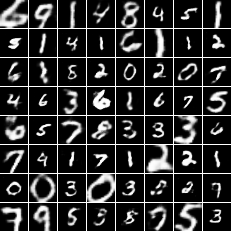

Target mask:


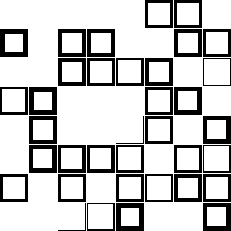

[     966 Epoch:[ 0/25] [ 166/1093] time: 56.8371, d_loss: 1.47903848, g_loss: 2.19099283, walk_loss: 2.19099283
Target image:


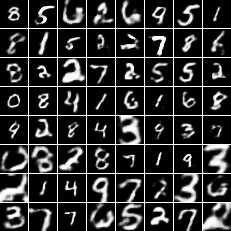

Target mask:


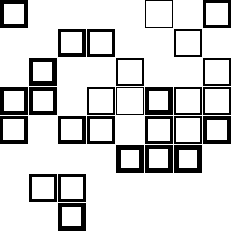

[     967 Epoch:[ 0/25] [ 167/1093] time: 57.1087, d_loss: 1.48776984, g_loss: 2.20606613, walk_loss: 2.20606613
Target image:


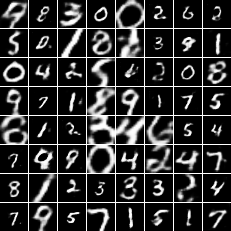

Target mask:


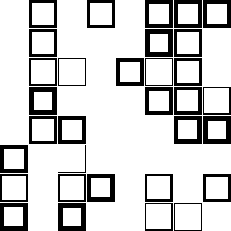

[     968 Epoch:[ 0/25] [ 168/1093] time: 57.3484, d_loss: 1.48564398, g_loss: 2.20757532, walk_loss: 2.20757532
Target image:


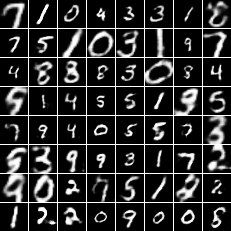

Target mask:


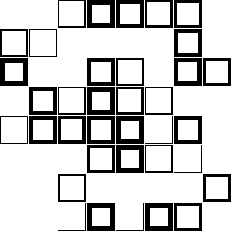

[     969 Epoch:[ 0/25] [ 169/1093] time: 57.6505, d_loss: 1.47765493, g_loss: 2.18732357, walk_loss: 2.18732357
Target image:


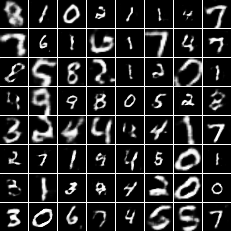

Target mask:


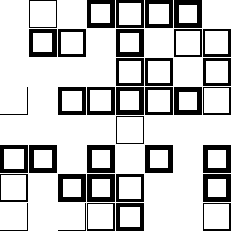

[     970 Epoch:[ 0/25] [ 170/1093] time: 57.9181, d_loss: 1.47590935, g_loss: 2.17672658, walk_loss: 2.17672658
Target image:


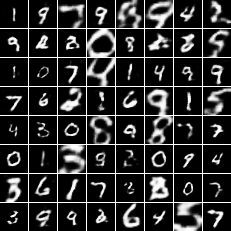

Target mask:


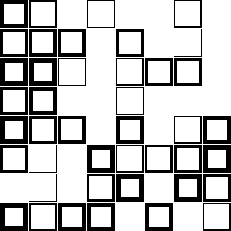

[     971 Epoch:[ 0/25] [ 171/1093] time: 58.2068, d_loss: 1.48473930, g_loss: 2.22459555, walk_loss: 2.22459531
Target image:


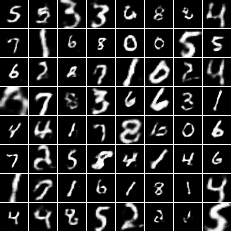

Target mask:


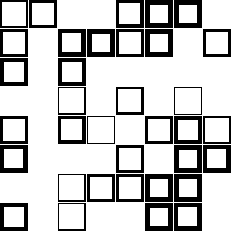

[     972 Epoch:[ 0/25] [ 172/1093] time: 58.4547, d_loss: 1.50314939, g_loss: 2.19628859, walk_loss: 2.19628882
Target image:


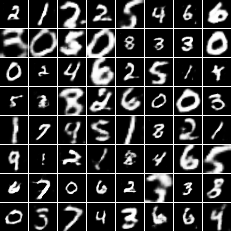

Target mask:


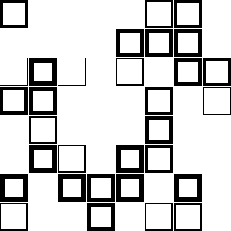

[     973 Epoch:[ 0/25] [ 173/1093] time: 58.6978, d_loss: 1.49207926, g_loss: 2.21040893, walk_loss: 2.21040893
Target image:


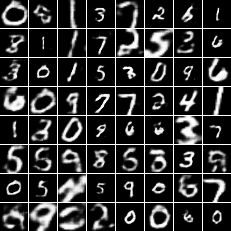

Target mask:


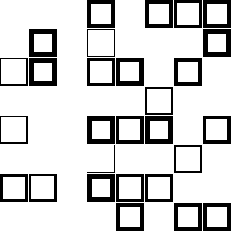

[     974 Epoch:[ 0/25] [ 174/1093] time: 58.9760, d_loss: 1.49641943, g_loss: 2.18515539, walk_loss: 2.18515491
Target image:


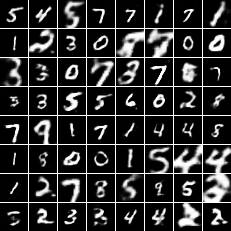

Target mask:


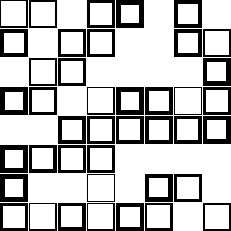

[     975 Epoch:[ 0/25] [ 175/1093] time: 59.2340, d_loss: 1.49643183, g_loss: 2.19741368, walk_loss: 2.19741368
Target image:


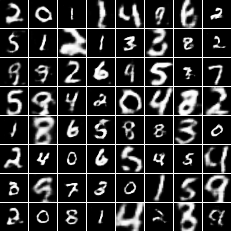

Target mask:


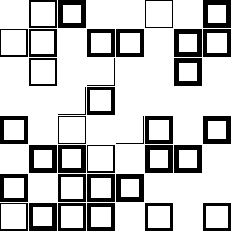

[     976 Epoch:[ 0/25] [ 176/1093] time: 59.5229, d_loss: 1.49194384, g_loss: 2.20649076, walk_loss: 2.20649076
Target image:


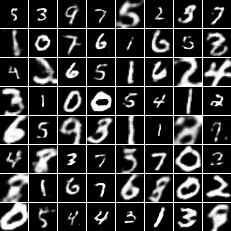

Target mask:


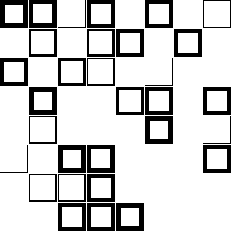

[     977 Epoch:[ 0/25] [ 177/1093] time: 59.7667, d_loss: 1.48909700, g_loss: 2.19904017, walk_loss: 2.19904017
Target image:


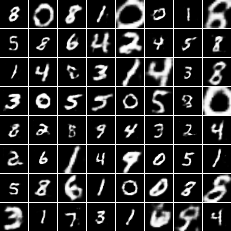

Target mask:


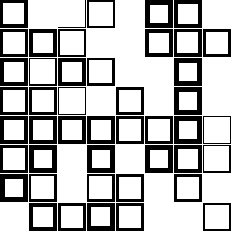

[     978 Epoch:[ 0/25] [ 178/1093] time: 60.0689, d_loss: 1.48261380, g_loss: 2.20540404, walk_loss: 2.20540404
Target image:


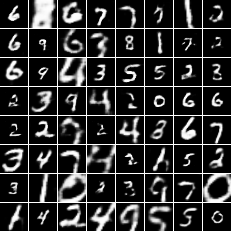

Target mask:


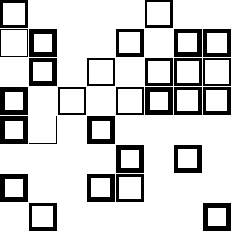

[     979 Epoch:[ 0/25] [ 179/1093] time: 60.3600, d_loss: 1.48188007, g_loss: 2.21079755, walk_loss: 2.21079755
Target image:


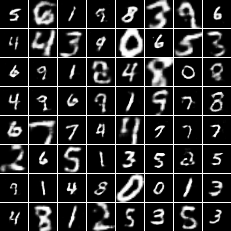

Target mask:


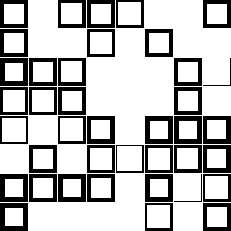

[     980 Epoch:[ 0/25] [ 180/1093] time: 60.6309, d_loss: 1.49853277, g_loss: 2.18186593, walk_loss: 2.18186593
Target image:


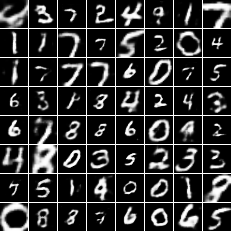

Target mask:


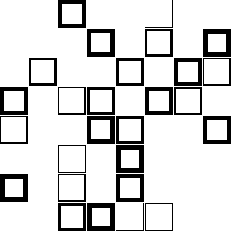

[     981 Epoch:[ 0/25] [ 181/1093] time: 60.9277, d_loss: 1.49572897, g_loss: 2.20314837, walk_loss: 2.20314837
Target image:


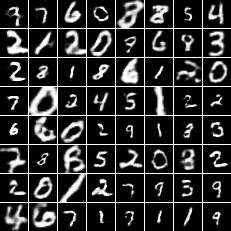

Target mask:


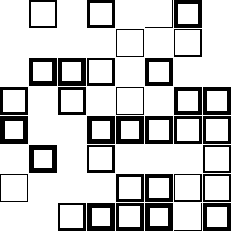

[     982 Epoch:[ 0/25] [ 182/1093] time: 61.2612, d_loss: 1.50468254, g_loss: 2.20330501, walk_loss: 2.20330501
Target image:


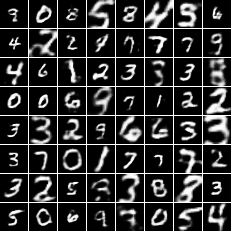

Target mask:


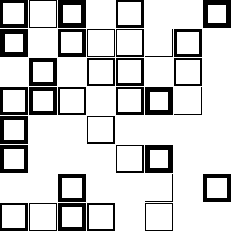

[     983 Epoch:[ 0/25] [ 183/1093] time: 61.5503, d_loss: 1.49317598, g_loss: 2.19579935, walk_loss: 2.19579935
Target image:


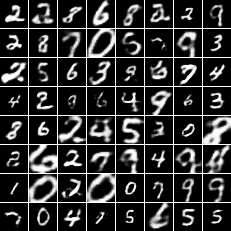

Target mask:


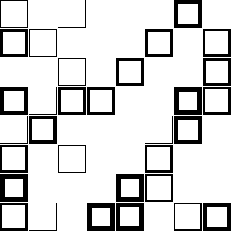

[     984 Epoch:[ 0/25] [ 184/1093] time: 61.8837, d_loss: 1.50097203, g_loss: 2.23198915, walk_loss: 2.23198915
Target image:


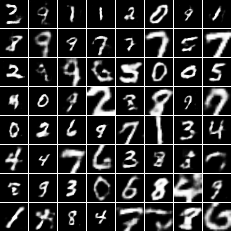

Target mask:


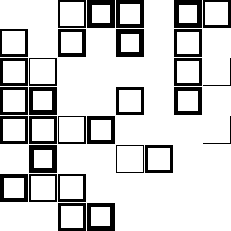

[     985 Epoch:[ 0/25] [ 185/1093] time: 62.1882, d_loss: 1.49332654, g_loss: 2.18346596, walk_loss: 2.18346596
Target image:


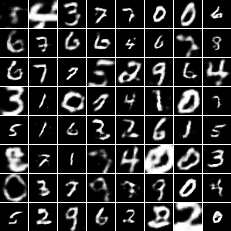

Target mask:


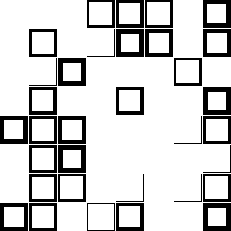

[     986 Epoch:[ 0/25] [ 186/1093] time: 62.4925, d_loss: 1.51786256, g_loss: 2.20395970, walk_loss: 2.20395970
Target image:


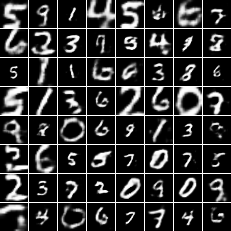

Target mask:


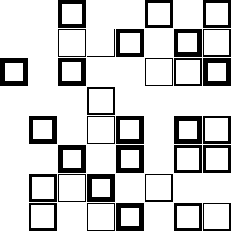

[     987 Epoch:[ 0/25] [ 187/1093] time: 62.7975, d_loss: 1.50557792, g_loss: 2.20858169, walk_loss: 2.20858169
Target image:


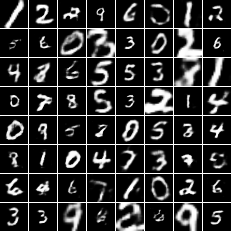

Target mask:


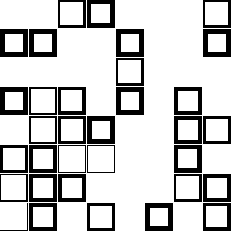

[     988 Epoch:[ 0/25] [ 188/1093] time: 63.1034, d_loss: 1.49738479, g_loss: 2.21642900, walk_loss: 2.21642923
Target image:


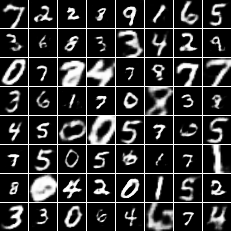

Target mask:


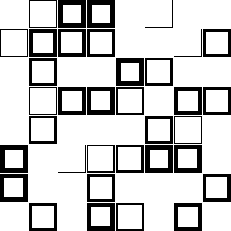

[     989 Epoch:[ 0/25] [ 189/1093] time: 63.4433, d_loss: 1.50869882, g_loss: 2.21797252, walk_loss: 2.21797252
Target image:


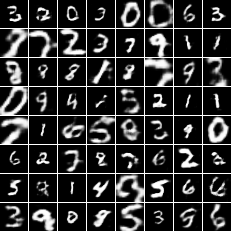

Target mask:


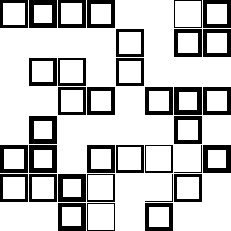

[     990 Epoch:[ 0/25] [ 190/1093] time: 63.7543, d_loss: 1.47637820, g_loss: 2.22807884, walk_loss: 2.22807932
Target image:


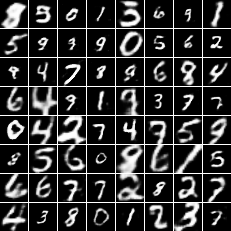

Target mask:


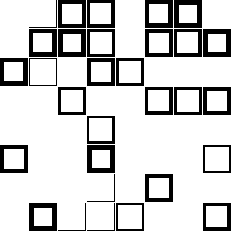

[     991 Epoch:[ 0/25] [ 191/1093] time: 64.0625, d_loss: 1.48737025, g_loss: 2.19913244, walk_loss: 2.19913220
Target image:


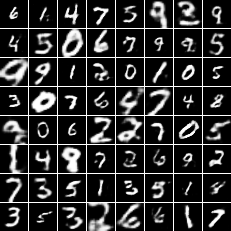

Target mask:


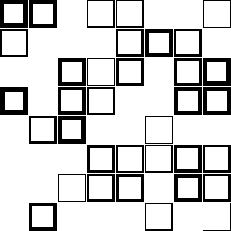

[     992 Epoch:[ 0/25] [ 192/1093] time: 64.3510, d_loss: 1.48694980, g_loss: 2.20028138, walk_loss: 2.20028138
Target image:


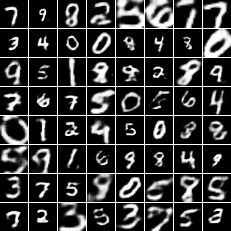

Target mask:


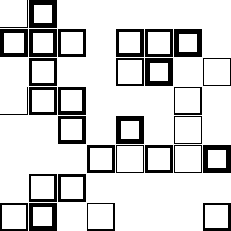

[     993 Epoch:[ 0/25] [ 193/1093] time: 64.6594, d_loss: 1.49199724, g_loss: 2.21282840, walk_loss: 2.21282840
Target image:


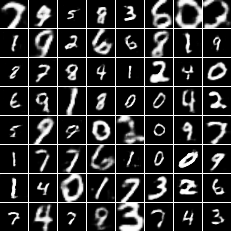

Target mask:


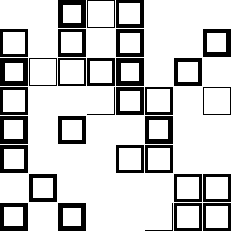

[     994 Epoch:[ 0/25] [ 194/1093] time: 64.9451, d_loss: 1.48685455, g_loss: 2.20212793, walk_loss: 2.20212793
Target image:


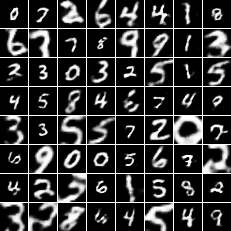

Target mask:


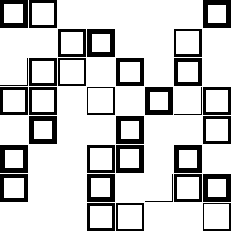

[     995 Epoch:[ 0/25] [ 195/1093] time: 65.2369, d_loss: 1.48347688, g_loss: 2.22337389, walk_loss: 2.22337389
Target image:


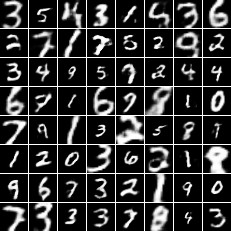

Target mask:


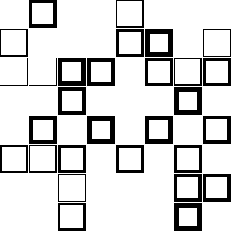

[     996 Epoch:[ 0/25] [ 196/1093] time: 65.5711, d_loss: 1.48273981, g_loss: 2.19435859, walk_loss: 2.19435835
Target image:


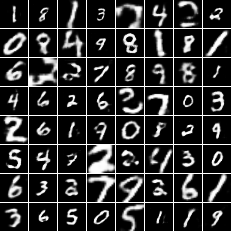

Target mask:


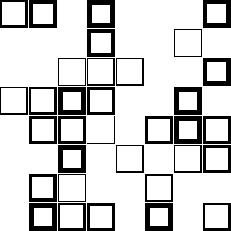

[     997 Epoch:[ 0/25] [ 197/1093] time: 65.8754, d_loss: 1.49381793, g_loss: 2.18111539, walk_loss: 2.18111539
Target image:


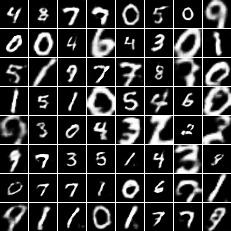

Target mask:


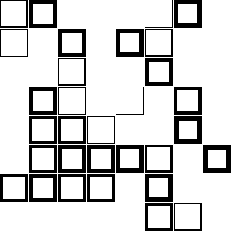

[     998 Epoch:[ 0/25] [ 198/1093] time: 66.1729, d_loss: 1.51005197, g_loss: 2.20071936, walk_loss: 2.20071888
Target image:


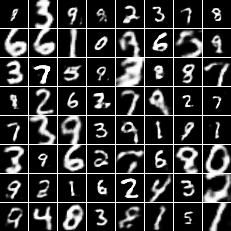

Target mask:


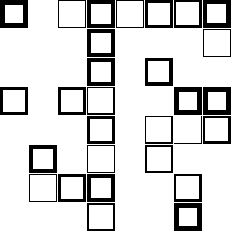

[     999 Epoch:[ 0/25] [ 199/1093] time: 66.4403, d_loss: 1.50412893, g_loss: 2.22617650, walk_loss: 2.22617650
Target image:


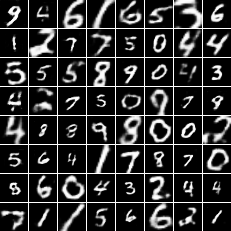

Target mask:


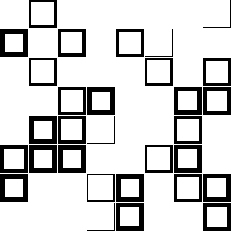

[    1000 Epoch:[ 0/25] [ 200/1093] time: 66.7036, d_loss: 1.49938595, g_loss: 2.21662450, walk_loss: 2.21662450
[Sample] d_loss: 1.8980910778045654, g_loss: 2.2941513061523438, w_loss: 2.2941513061523438


KeyboardInterrupt: 

In [3]:
tf.app.run(argv=['--dataset', 'mnist', '--input_height=28', '--output_height=28', '--train', '--out_name=ckpt'])

In [ ]:
# !tensorboard --logdir ./out/ckpt/logs

In [ ]:
# python train.py --dataset mnist --input_height 28 --output_height=28 --train --out_name zoom_argminGW_lr0.0002